In [2]:
# GPU Parallelism Utilities

import threading
import torch
import torch.multiprocessing as mp
from torch.nn.parallel import DataParallel
from queue import Queue
import gc
import sys
from pathlib import Path

# Add models path to import our custom FlexibleDataParallel
try:
    from src.models.dataparallel_utils import FlexibleDataParallel
except ImportError:
    # Define the class here as a fallback
    class FlexibleDataParallel(DataParallel):
        """
        Custom DataParallel that correctly handles attribute access
        """
        def __getattr__(self, name):
            try:
                return super().__getattr__(name)
            except AttributeError:
                return getattr(self.module, name)

# 1. DataParallel Wrapper for models
def apply_data_parallel(model, device):
    """Apply DataParallel to split batches across GPU threads if using CUDA"""
    if torch.cuda.is_available() and 'cuda' in str(device):
        # Use our custom FlexibleDataParallel instead of regular DataParallel
        return FlexibleDataParallel(model).to(device)
    return model.to(device)

# 2. Memory Management Utilities
def get_gpu_memory_info():
    """Get GPU memory usage information"""
    if torch.cuda.is_available():
        # Get stats for the current device
        device_idx = torch.cuda.current_device()
        stats = torch.cuda.memory_stats(device_idx)
        # Find total, allocated, and free memory
        total_memory = torch.cuda.get_device_properties(device_idx).total_memory / (1024**3)  # GB
        allocated = stats["allocated_bytes.all.current"] / (1024**3)  # GB
        free_memory = total_memory - allocated
        return {
            "total_memory_gb": total_memory,
            "allocated_memory_gb": allocated,
            "free_memory_gb": free_memory,
            "device": torch.cuda.get_device_name(device_idx)
        }
    return {"device": "CPU", "total_memory_gb": 0, "allocated_memory_gb": 0, "free_memory_gb": 0}

def clear_gpu_memory():
    """Aggressively clear GPU memory"""
    if torch.cuda.is_available():
        torch.cuda.empty_cache()
        gc.collect()

# 3. Concurrent Model Training with Threading
class ConcurrentTrainer:
    """Class for training multiple models concurrently on a single GPU"""
    def __init__(self, configs, dataloaders, device, max_concurrent=2):
        self.configs = configs
        self.dataloaders = dataloaders
        self.device = device
        self.max_concurrent = max_concurrent
        self.results = []
        self.lock = threading.Lock()
        self.active_count = 0

    def _train_model_thread(self, config, idx, result_queue):
        """Thread worker function to train a model"""
        try:
            with self.lock:  # Track active thread count
                self.active_count += 1

            # Print memory info before training
            memory_info = get_gpu_memory_info()
            print(f"\nStarting training for {config['name']} | "
                  f"GPU Memory: {memory_info['free_memory_gb']:.2f}GB free")

            # Train model
            results = train_model_with_config(config, self.dataloaders, self.device)

            # Evaluate on test set
            eval_metrics = evaluate_model_on_test(
                results['model'],
                test_loader,
                self.device,
                class_names,
                model_name=config['name']
            )

            # Combine results
            complete_results = {
                'model_name': config['name'],
                'architecture': config['model']['architecture'],
                'config': config,
                'training_time': results['training_time'],
                'best_val_acc': results['training_stats']['best_val_acc'],
                'best_epoch': results['training_stats']['best_epoch'],
                'test_accuracy': eval_metrics['accuracy'],
                'f1_score': eval_metrics['f1_score'],
                'precision': eval_metrics['precision'],
                'recall': eval_metrics['recall']
            }

            # Save model
            timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
            if IN_COLAB:
                save_dir = os.path.join(project_root, "experiments", f"{config['name'].lower().replace(' ', '_')}_{timestamp}")
            else:
                save_dir = os.path.join(project_root, "experiments", f"{config['name'].lower().replace(' ', '_')}_{timestamp}")

            os.makedirs(save_dir, exist_ok=True)
            save_path = os.path.join(save_dir, f"{config['name'].lower().replace(' ', '_')}.pt")

            save_model(
                results['model'],
                config,
                save_path,
                metrics={
                    'accuracy': eval_metrics['accuracy'],
                    'f1_macro': eval_metrics['f1_score'],
                    'best_val_acc': results['training_stats']['best_val_acc'],
                    'best_epoch': results['training_stats']['best_epoch']
                },
                epoch=results['training_stats']['best_epoch']
            )

            print(f"Model saved to {save_path}")

            # Add to results queue
            result_queue.put((idx, complete_results))

            # Clear GPU memory
            del results['model']
            clear_gpu_memory()

        except Exception as e:
            print(f"Error training {config['name']}: {e}")
            result_queue.put((idx, None))

        finally:
            with self.lock:  # Update active thread count
                self.active_count -= 1

    def train_all_models(self):
        """Train all models with controlled concurrency"""
        memory_info = get_gpu_memory_info()
        print(f"\nGPU Memory Information before training:")
        print(f"Device: {memory_info['device']}")
        print(f"Total Memory: {memory_info['total_memory_gb']:.2f} GB")
        print(f"Allocated Memory: {memory_info['allocated_memory_gb']:.2f} GB")
        print(f"Free Memory: {memory_info['free_memory_gb']:.2f} GB")

        result_queue = Queue()
        threads = []
        results = [None] * len(self.configs)

        # Create a thread for each model configuration
        for idx, config in enumerate(self.configs):
            thread = threading.Thread(
                target=self._train_model_thread,
                args=(config, idx, result_queue)
            )
            threads.append(thread)

        # Start threads with controlled concurrency
        running_threads = []
        for thread in threads:
            # Wait if we've reached max concurrent threads
            while self.active_count >= self.max_concurrent:
                # Check if any results are ready
                if not result_queue.empty():
                    idx, result = result_queue.get()
                    if result is not None:
                        results[idx] = result
                time.sleep(1)  # Sleep briefly before checking again

            # Start the thread
            thread.start()
            running_threads.append(thread)

        # Collect remaining results
        for thread in running_threads:
            thread.join()

        # Get any remaining results
        while not result_queue.empty():
            idx, result = result_queue.get()
            if result is not None:
                results[idx] = result

        # Filter out any None results (from errors)
        self.results = [r for r in results if r is not None]
        return self.results

# Let user decide how many concurrent models to train based on their GPU
def check_gpu_and_suggest_concurrency():
    """Check GPU and suggest concurrency level based on memory"""
    if not torch.cuda.is_available():
        print("No GPU detected. Will run models sequentially.")
        return 1

    memory_info = get_gpu_memory_info()
    total_gb = memory_info['total_memory_gb']
    print(f"\nGPU: {memory_info['device']}")
    print(f"Total Memory: {total_gb:.2f} GB")
    print(f"Free Memory: {memory_info['free_memory_gb']:.2f} GB")

    # Suggestion based on total memory
    if total_gb >= 24:  # High-end GPUs
        suggested = 3
    elif total_gb >= 12:  # Mid-range GPUs
        suggested = 2
    else:  # Low-end GPUs
        suggested = 1

    print(f"\nBased on your GPU memory, suggested concurrent models: {suggested}")
    return suggested

# Check GPU and get recommended concurrency
concurrent_models = check_gpu_and_suggest_concurrency()


GPU: Tesla T4
Total Memory: 14.74 GB
Free Memory: 14.74 GB

Based on your GPU memory, suggested concurrent models: 2


# Flexible CNN Architecture Comparison for Musical Instrument Classification

This notebook implements an approach to compare different configurations of our CustomCNN model using the flexible framework. We'll train and evaluate multiple CNN architectures to find the optimal configuration for musical instrument classification.

## Approach Overview

1. **Environment Setup**: Configure the Colab environment and import necessary modules
2. **Dataset Preparation**: Load and preprocess the dataset once for all models
3. **Model Configurations**: Define multiple CustomCNN variants with different architectures
4. **Sequential Training**: Train each model variant and track performance metrics
5. **Comparison Analysis**: Compare model variants and identify the best-performing architecture
6. **Visualization**: Create comparative visualizations of model performance

We'll use our `FlexibleCNN` model which allows us to experiment with different architectures through configuration rather than code changes.

In [ ]:
# Setup: Add project root to path to enable imports from src
import os
import sys
import yaml
import json
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import torch
import torch.nn as nn
import time
from pathlib import Path
from tqdm import tqdm.notebook
from datetime import datetime

# Check if we're running in Google Colab
import importlib.util
IN_COLAB = importlib.util.find_spec("google.colab") is not None

# Get the current directory
current_dir = os.getcwd()
print(f"Current directory: {current_dir}")


if IN_COLAB:
    # Add project root to path to ensure imports work correctly
    project_root = os.path.join(current_dir, "MIC-MA1")
    sys.path.insert(0, project_root)
    print(f"Project root added to path: {project_root}")
else:
    # Running locally
    project_root = str(Path(current_dir).parent)
    sys.path.append(project_root)
    print(f"Running locally, project root: {project_root}")
    print("💻 Running locally - using local environment")

# Import our project modules
from scripts.colab_integration import setup_colab_environment, check_gpu
from src.data.preprocessing import get_preprocessing_transforms
from src.data.augmentation import AdvancedAugmentation
from src.data.dataloader import load_datasets
from src.models.baseline import get_resnet18_model, unfreeze_layers
from src.models.custom_cnn import create_custom_cnn
from src.models.flexible_cnn import FlexibleCNN, create_flexible_cnn
from src.training.trainer import train_model, evaluate_model
from src.training.metrics import compute_metrics, get_confusion_matrix
from src.visualization.plotting import plot_training_history, plot_confusion_matrix, plot_sample_predictions, plot_sample_images
from src.models.model_utils import save_model

if IN_COLAB:
    print("🚀 Running in Google Colab - setting up environment...")
    setup_colab_environment()  # This handles all the Colab-specific setup

# Check for TPU and GPU availability
try:
    import torch_xla
    import torch_xla.core.xla_model as xm
    device = xm.xla_device()
    print("Using TPU:", device)
except ImportError:
    device = check_gpu()  # Your utility function for GPU detection
    print("Using device:", device)

# Set random seeds for reproducibility
torch.manual_seed(42)
np.random.seed(42)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(42)

Current directory: /content
Project root added to path: /content/MIC-MA1
🚀 Running in Google Colab - setting up environment...
Setting up Colab environment for Musical Instrument Classification...
Running in Google Colab environment
Installing dependencies...
Environment setup complete!
Using device: cuda
GPU available: Tesla T4
Memory allocated: 0.00 GB
Memory cached: 0.00 GB
Using device: cuda


## 1. Dataset Preparation

We'll load our dataset once and use it for all model variants to ensure fair comparison:

Using data directory: /content/MIC-MA1/data/raw/30_Musical_Instruments
Using advanced augmentation with strength: medium

Dataset loaded successfully:
- Number of classes: 30
- Training samples: 4793
- Validation samples: 150
- Test samples: 150

Sample classes: ['Didgeridoo', 'Tambourine', 'Xylophone', 'acordian', 'alphorn']...

Sample training images:


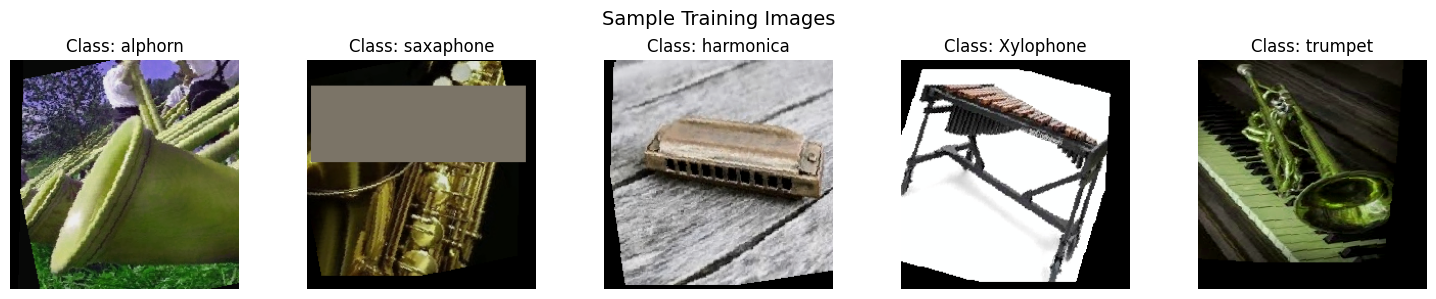

In [4]:
# Default data configuration
data_config = {
    'img_size': 224,
    'batch_size': 32,
    'num_workers': 2 if IN_COLAB else 4,
    'pin_memory': True,
    'augmentation_strength': 'medium'
}

# Set data directory
if IN_COLAB:
    # Adjust path based on your Google Drive structure
    data_dir = os.path.join(project_root, "data/raw/30_Musical_Instruments")
    if not os.path.exists(data_dir):
        print("⚠️ Dataset not found in the expected location")
        print("Please upload the dataset to the correct location in Google Drive")
else:
    data_dir = os.path.join(project_root, "data/raw/30_Musical_Instruments")

print(f"Using data directory: {data_dir}")

# Get advanced transforms with the specified strength
print(f"Using advanced augmentation with strength: {data_config['augmentation_strength']}")
transforms = AdvancedAugmentation.get_advanced_transforms(
    img_size=data_config['img_size'],
    augmentation_strength=data_config['augmentation_strength']
)

# Load datasets using our utility function
try:
    data = load_datasets(
        data_dir=data_dir,
        transforms=transforms,
        batch_size=data_config['batch_size'],
        num_workers=data_config['num_workers'],
        pin_memory=data_config['pin_memory']
    )

    # Access the components
    train_loader = data['dataloaders']['train']
    valid_loader = data['dataloaders']['val']
    test_loader = data['dataloaders']['test']

    # Get class information
    class_names = list(data['class_mappings']['idx_to_class'].values())
    num_classes = data['num_classes']

    print(f"\nDataset loaded successfully:")
    print(f"- Number of classes: {num_classes}")
    print(f"- Training samples: {len(data['datasets']['train'])}")
    print(f"- Validation samples: {len(data['datasets']['val'])}")
    print(f"- Test samples: {len(data['datasets']['test'])}")

    # Display a few class names
    print(f"\nSample classes: {class_names[:5]}...")

    # Prepare dataloaders dictionary for training
    dataloaders = {
        'train': train_loader,
        'val': valid_loader
    }

    # Visualize some sample images
    print("\nSample training images:")
    plot_sample_images(
        dataset=data['datasets']['train'],
        class_mapping=data['class_mappings']['idx_to_class'],
        num_images=5,
        title="Sample Training Images"
    )
except Exception as e:
    print(f"Error loading datasets: {e}")

## 2. Model Configurations

We'll define multiple configurations for our CNN models to compare:

1. **Base Custom CNN** - Using the CustomMusicCNN architecture from notebook 3_Model_From_Scratch
2. **Deeper Custom CNN** - A deeper architecture with an additional convolutional block
3. **Wider Custom CNN** - A wider architecture with more filters in each layer
4. **Regularized Custom CNN** - A variant with stronger regularization
5. **ResNet18 Baseline** - For comparison with a standard architecture

All models will be trained for 50 epochs to match the training regime in notebook 3.

In [5]:
# Define various model configurations

# 1. Base Custom CNN configuration (using the CustomMusicCNN architecture from notebook 3)
base_cnn_config = {
    'model': {
        'architecture': 'custom_cnn',  # Changed to use CustomMusicCNN from notebook 3
        'input_channels': 3,
        'num_classes': num_classes
    },
    'training': {
        'num_epochs': 50,  # Changed from 30 to 50 to match notebook 3
        'batch_size': 32,
        'optimizer': {
            'name': 'adamw',
            'learning_rate': 0.001,
            'weight_decay': 0.0005
        },
        'scheduler': {
            'name': 'onecycle',
            'max_lr': 0.01
        }
    },
    'name': 'Base CNN'
}

# 2. Deeper Custom CNN configuration
deeper_cnn_config = {
    'model': {
        'architecture': 'flexible_cnn',
        'input_channels': 3,
        'num_classes': num_classes,
        'conv_layers': [32, 64, 128, 256, 512, 512],  # Added an extra layer
        'fc_layers': [512, 256],
        'kernel_size': 3,
        'pool_size': 2,
        'dropout': [0.1, 0.2, 0.3, 0.4, 0.5, 0.5, 0.5],  # Progressive dropout
        'activation': 'relu',
        'pooling_type': 'max',
        'use_batch_norm': True
    },
    'training': {
        'num_epochs': 50,  # Changed from 30 to 50
        'batch_size': 32,
        'optimizer': {
            'name': 'adamw',
            'learning_rate': 0.001,
            'weight_decay': 0.0005
        },
        'scheduler': {
            'name': 'onecycle',
            'max_lr': 0.01
        }
    },
    'name': 'Deeper CNN'
}

# 3. Wider Custom CNN configuration
wider_cnn_config = {
    'model': {
        'architecture': 'flexible_cnn',
        'input_channels': 3,
        'num_classes': num_classes,
        'conv_layers': [64, 128, 256, 512, 1024],  # Doubled filter count in last layer
        'fc_layers': [1024, 512],  # Wider fully connected layers
        'kernel_size': 3,
        'pool_size': 2,
        'dropout': 0.5,
        'activation': 'relu',
        'pooling_type': 'max',
        'use_batch_norm': True
    },
    'training': {
        'num_epochs': 50,  # Changed from 30 to 50
        'batch_size': 32,
        'optimizer': {
            'name': 'adamw',
            'learning_rate': 0.001,
            'weight_decay': 0.0005
        },
        'scheduler': {
            'name': 'onecycle',
            'max_lr': 0.01
        }
    },
    'name': 'Wider CNN'
}

# 4. Regularized Custom CNN configuration
regularized_cnn_config = {
    'model': {
        'architecture': 'flexible_cnn',
        'input_channels': 3,
        'num_classes': num_classes,
        'conv_layers': [32, 64, 128, 256, 512],
        'fc_layers': [512, 256],
        'kernel_size': 3,
        'pool_size': 2,
        'dropout': [0.2, 0.3, 0.4, 0.5, 0.6, 0.6, 0.6],  # Higher dropout rates
        'activation': 'relu',
        'pooling_type': 'max',
        'use_batch_norm': True
    },
    'training': {
        'num_epochs': 50,  # Changed from 30 to 50
        'batch_size': 32,
        'optimizer': {
            'name': 'adamw',
            'learning_rate': 0.001,
            'weight_decay': 0.001  # Increased weight decay
        },
        'scheduler': {
            'name': 'onecycle',
            'max_lr': 0.01
        }
    },
    'name': 'Regularized CNN'
}

# 5. ResNet18 Baseline (for comparison)
resnet18_config = {
    'model': {
        'architecture': 'resnet18',
        'pretrained': True,
        'feature_extracting': False,  # Full fine-tuning
        'num_classes': num_classes,
        'unfreeze_layers': ['layer4', 'fc']
    },
    'training': {
        'num_epochs': 50,  # Changed from 30 to 50
        'batch_size': 32,
        'optimizer': {
            'name': 'adamw',
            'learning_rate': 0.001,
            'weight_decay': 0.0005
        },
        'scheduler': {
            'name': 'onecycle',
            'max_lr': 0.01
        }
    },
    'name': 'ResNet18'
}

# Create a list of configurations to iterate through
model_configs = [
    base_cnn_config,
    deeper_cnn_config,
    wider_cnn_config,
    regularized_cnn_config,
    resnet18_config
]

# Print configuration summary
print("Model configurations to compare:")
for config in model_configs:
    if config['model']['architecture'] == 'flexible_cnn':
        print(f"\n{config['name']}:")
        print(f"- Architecture: {config['model']['architecture']}")
        print(f"- Conv layers: {config['model']['conv_layers']}")
        print(f"- FC layers: {config['model']['fc_layers']}")
        print(f"- Dropout: {config['model']['dropout']}")
    elif config['model']['architecture'] == 'custom_cnn':
        print(f"\n{config['name']}:")
        print(f"- Architecture: {config['model']['architecture']}")
        print(f"- Input channels: {config['model']['input_channels']}")
        print(f"- Num classes: {config['model']['num_classes']}")
    elif config['model']['architecture'] == 'resnet18':
        print(f"\n{config['name']}:")
        print(f"- Architecture: {config['model']['architecture']}")
        print(f"- Pretrained: {config['model']['pretrained']}")
        print(f"- Feature extracting: {config['model']['feature_extracting']}")

Model configurations to compare:

Base CNN:
- Architecture: custom_cnn
- Input channels: 3
- Num classes: 30

Deeper CNN:
- Architecture: flexible_cnn
- Conv layers: [32, 64, 128, 256, 512, 512]
- FC layers: [512, 256]
- Dropout: [0.1, 0.2, 0.3, 0.4, 0.5, 0.5, 0.5]

Wider CNN:
- Architecture: flexible_cnn
- Conv layers: [64, 128, 256, 512, 1024]
- FC layers: [1024, 512]
- Dropout: 0.5

Regularized CNN:
- Architecture: flexible_cnn
- Conv layers: [32, 64, 128, 256, 512]
- FC layers: [512, 256]
- Dropout: [0.2, 0.3, 0.4, 0.5, 0.6, 0.6, 0.6]

ResNet18:
- Architecture: resnet18
- Pretrained: True
- Feature extracting: False


## 3. Model Creation and Training Functions

Let's create utility functions to instantiate models and train them:

In [6]:
def create_model(config, device):
    """Create model based on configuration"""
    model_config = config['model']
    architecture = model_config.get('architecture', 'resnet18').lower()

    if architecture == 'resnet18':
        pretrained = model_config.get('pretrained', True)
        feature_extracting = model_config.get('feature_extracting', True)

        model = get_resnet18_model(
            num_classes=model_config['num_classes'],
            pretrained=pretrained,
            feature_extracting=feature_extracting
        )

        # Unfreeze specific layers if specified
        if not feature_extracting and 'unfreeze_layers' in model_config:
            model, _ = unfreeze_layers(model, model_config['unfreeze_layers'])

    elif architecture == 'custom_cnn':
        # Create the same custom CNN from notebook 3
        model = create_custom_cnn(
            num_classes=model_config['num_classes'],
            input_channels=model_config.get('input_channels', 3)
        )
    elif architecture == 'flexible_cnn':
        model = create_flexible_cnn(config)
    else:
        raise ValueError(f"Unsupported architecture: {architecture}")

    return model.to(device)

def create_optimizer(config, model_parameters):
    """Create optimizer based on configuration"""
    optimizer_config = config['training']['optimizer']
    optimizer_name = optimizer_config.get('name', 'adam').lower()
    lr = optimizer_config.get('learning_rate', 0.001)
    weight_decay = optimizer_config.get('weight_decay', 0.0001)

    if optimizer_name == 'adam':
        return torch.optim.Adam(
            model_parameters,
            lr=lr,
            weight_decay=weight_decay,
            betas=(
                optimizer_config.get('beta1', 0.9),
                optimizer_config.get('beta2', 0.999)
            )
        )
    elif optimizer_name == 'adamw':
        return torch.optim.AdamW(
            model_parameters,
            lr=lr,
            weight_decay=weight_decay,
            betas=(
                optimizer_config.get('beta1', 0.9),
                optimizer_config.get('beta2', 0.999)
            )
        )
    elif optimizer_name == 'sgd':
        return torch.optim.SGD(
            model_parameters,
            lr=lr,
            momentum=optimizer_config.get('momentum', 0.9),
            weight_decay=weight_decay,
            nesterov=optimizer_config.get('nesterov', True)
        )
    else:
        raise ValueError(f"Unsupported optimizer: {optimizer_name}")

def create_scheduler(config, optimizer, steps_per_epoch=None):
    """Create learning rate scheduler based on configuration"""
    scheduler_config = config['training'].get('scheduler', {})
    scheduler_name = scheduler_config.get('name', '').lower()

    if not scheduler_name:
        return None

    if scheduler_name == 'step':
        return torch.optim.lr_scheduler.StepLR(
            optimizer,
            step_size=scheduler_config.get('step_size', 7),
            gamma=scheduler_config.get('gamma', 0.1)
        )
    elif scheduler_name == 'cosine':
        return torch.optim.lr_scheduler.CosineAnnealingLR(
            optimizer,
            T_max=scheduler_config.get('t_max', config['training']['num_epochs']),
            eta_min=scheduler_config.get('eta_min', 0)
        )
    elif scheduler_name == 'plateau':
        return torch.optim.lr_scheduler.ReduceLROnPlateau(
            optimizer,
            mode='min',
            factor=scheduler_config.get('factor', 0.1),
            patience=scheduler_config.get('patience', 5),
            min_lr=scheduler_config.get('min_lr', 1e-6)
        )
    elif scheduler_name == 'onecycle' and steps_per_epoch:
        return torch.optim.lr_scheduler.OneCycleLR(
            optimizer,
            max_lr=scheduler_config.get('max_lr', 0.01),
            steps_per_epoch=steps_per_epoch,
            epochs=config['training']['num_epochs'],
            pct_start=scheduler_config.get('pct_start', 0.3)
        )
    else:
        print(f"Warning: Scheduler {scheduler_name} not configured correctly, using no scheduler")
        return None

## 4. Function to Train Models and Track Results

Now we'll create a function to train a model with a given configuration and track the results:

In [7]:
def train_model_with_config(config, dataloaders, device):
    """
    Train a model with the specified configuration and return the results

    Args:
        config (dict): Model and training configuration
        dataloaders (dict): Dictionary with 'train' and 'val' dataloaders
        device (torch.device): Device to train on

    Returns:
        dict: Results including model, metrics, and training time
    """
    print(f"\n{'='*80}")
    print(f"Training model: {config['name']}")
    print(f"Architecture: {config['model']['architecture']}")
    print(f"{'='*80}")

    # Record start time
    start_time = time.time()

    # Create model
    model = create_model(config, device)

    # Create optimizer
    optimizer = create_optimizer(config, model.parameters())

    # Create scheduler
    scheduler = create_scheduler(
        config,
        optimizer,
        steps_per_epoch=len(dataloaders['train'])
    )

    # Set up loss function
    criterion = nn.CrossEntropyLoss()

    # Train model
    model, history, training_stats = train_model(
        model,
        dataloaders,
        criterion,
        optimizer,
        device,
        scheduler=scheduler,
        num_epochs=config['training']['num_epochs'],
        verbose=True
    )

    # Record training time
    training_time = time.time() - start_time

    # Save results
    results = {
        'model': model,
        'config': config,
        'history': history,
        'training_stats': training_stats,
        'training_time': training_time
    }

    print(f"\nTraining completed in {training_time:.2f} seconds")
    print(f"Best validation accuracy: {training_stats['best_val_acc']:.4f} at epoch {training_stats['best_epoch']}")

    # Plot training history
    plot_training_history(history)

    # Return results for comparison
    return results

## 5. Model Evaluation Function

Next, we'll create a function to evaluate models on the test set:

In [8]:
def evaluate_model_on_test(model, test_loader, device, class_names, model_name=None):
    """
    Evaluate a trained model on the test set

    Args:
        model (nn.Module): Trained model
        test_loader (DataLoader): Test data loader
        device (torch.device): Device to evaluate on
        class_names (list): List of class names
        model_name (str): Name of the model for display

    Returns:
        dict: Evaluation metrics
    """
    print(f"\n{'='*80}")
    print(f"Evaluating model{': ' + model_name if model_name else ''} on test set")
    print(f"{'='*80}")

    # Evaluate model
    test_accuracy, test_preds, test_labels = evaluate_model(
        model,
        test_loader,
        device,
        verbose=True
    )

    # Compute metrics
    metrics = compute_metrics(test_labels, test_preds, class_names)

    print(f"Test Accuracy: {metrics['accuracy']:.4f}")
    print(f"Macro-average F1 Score: {metrics['macro_avg']['f1']:.4f}")
    print(f"Macro-average Precision: {metrics['macro_avg']['precision']:.4f}")
    print(f"Macro-average Recall: {metrics['macro_avg']['recall']:.4f}")

    # Plot confusion matrix
    cm = get_confusion_matrix(test_labels, test_preds)
    plot_confusion_matrix(
        cm,
        class_names,
        figsize=(12, 10),
        fontsize=8,
        title=f"Confusion Matrix - {model_name if model_name else 'Model'}"
    )

    # Return metrics
    return {
        'accuracy': metrics['accuracy'],
        'f1_score': metrics['macro_avg']['f1'],
        'precision': metrics['macro_avg']['precision'],
        'recall': metrics['macro_avg']['recall'],
        'predictions': test_preds,
        'labels': test_labels
    }

## 6. GPU Parallelism Strategies

To effectively utilize a single GPU's multiple cores and parallel processing capabilities, we can employ several strategies:

1. **DataParallel for Batch Splitting**: PyTorch's DataParallel splits batches across available GPU threads
2. **Memory-Efficient Training**: Train models in sequence but with optimized batch sizes
3. **Concurrent Training with Memory Management**: Use Python's threading to manage multiple models training concurrently

Let's implement these approaches:

## 6. Sequential Training of Models

Now let's train each model configuration sequentially and collect results:

In [9]:
# Option 1: Apply DataParallel to models for better utilization of single GPU
print("\nApplying DataParallel to models for batch parallelism on GPU")

# Function to train with DataParallel
def train_with_data_parallel():
    all_results = []

    # Train each model configuration sequentially but with DataParallel
    for config in model_configs:
        try:
            # Temporarily increase batch size for better parallelism if memory allows
            original_batch_size = config['training'].get('batch_size', 32)
            memory_info = get_gpu_memory_info()

            # If enough GPU memory, double the batch size for DataParallel
            if memory_info['free_memory_gb'] > 4 and torch.cuda.device_count() > 0:
                config['training']['batch_size'] = original_batch_size * 2
                print(f"\nIncreased batch size to {config['training']['batch_size']} for {config['name']}")

            # Create model with DataParallel
            model = create_model(config, device)
            model = apply_data_parallel(model, device)

            # Create optimizer and scheduler
            optimizer = create_optimizer(config, model.parameters())
            scheduler = create_scheduler(
                config,
                optimizer,
                steps_per_epoch=len(dataloaders['train'])
            )

            # Set up loss function
            criterion = nn.CrossEntropyLoss()

            # Record start time
            start_time = time.time()

            # Train model
            print(f"\n{'='*80}")
            print(f"Training model with DataParallel: {config['name']}")
            print(f"{'='*80}")

            model, history, training_stats = train_model(
                model,
                dataloaders,
                criterion,
                optimizer,
                device,
                scheduler=scheduler,
                num_epochs=config['training']['num_epochs'],
                verbose=True
            )

            # Record training time
            training_time = time.time() - start_time

            # Restore original batch size
            config['training']['batch_size'] = original_batch_size

            # Evaluate on test set
            eval_metrics = evaluate_model_on_test(
                model,
                test_loader,
                device,
                class_names,
                model_name=config['name']
            )

            # Combine results
            complete_results = {
                'model_name': config['name'],
                'architecture': config['model']['architecture'],
                'config': config,
                'training_time': training_time,
                'best_val_acc': training_stats['best_val_acc'],
                'best_epoch': training_stats['best_epoch'],
                'test_accuracy': eval_metrics['accuracy'],
                'f1_score': eval_metrics['f1_score'],
                'precision': eval_metrics['precision'],
                'recall': eval_metrics['recall']
            }

            # Add to results list
            all_results.append(complete_results)

            # Optional: Save the model
            timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
            save_dir = os.path.join(project_root, "experiments",
                                   f"{config['name'].lower().replace(' ', '_')}_{timestamp}")

            os.makedirs(save_dir, exist_ok=True)
            save_path = os.path.join(save_dir, f"{config['name'].lower().replace(' ', '_')}.pt")

            save_model(
                model,
                config,
                save_path,
                metrics={
                    'accuracy': eval_metrics['accuracy'],
                    'f1_macro': eval_metrics['f1_score'],
                    'best_val_acc': training_stats['best_val_acc'],
                    'best_epoch': training_stats['best_epoch']
                },
                epoch=training_stats['best_epoch']
            )

            print(f"Model saved to {save_path}")

            # Plot training history
            plot_training_history(history)

            # Clear CUDA cache between models if using GPU
            if torch.cuda.is_available():
                del model
                torch.cuda.empty_cache()

        except Exception as e:
            print(f"Error training {config['name']}: {e}")
            # Continue with next model on error
            continue

    print("\nAll models trained and evaluated with DataParallel!")
    return all_results


Applying DataParallel to models for batch parallelism on GPU


In [10]:
# Option 2: Concurrent model training with memory management
print("\nSetting up concurrent training with threading")

# Function to train with ConcurrentTrainer
def train_with_concurrent_trainer(max_concurrent=concurrent_models):
    trainer = ConcurrentTrainer(
        configs=model_configs,
        dataloaders=dataloaders,
        device=device,
        max_concurrent=max_concurrent
    )

    print(f"Training {len(model_configs)} models with up to {max_concurrent} running concurrently")
    all_results = trainer.train_all_models()
    print("\nAll models trained and evaluated concurrently!")
    return all_results


Setting up concurrent training with threading



🚀 Using DataParallel approach for GPU utilization

Increased batch size to 64 for Base CNN

Training model with DataParallel: Base CNN
Epoch 1/50
----------


train Epoch 1/50:   0%|          | 0/150 [00:00<?, ?it/s]

train Loss: 3.2268 Acc: 0.1077


val Epoch 1/50:   0%|          | 0/5 [00:00<?, ?it/s]

val Loss: 3.0157 Acc: 0.1000
New best model found! Val accuracy: 0.1000

Epoch 2/50
----------


train Epoch 2/50:   0%|          | 0/150 [00:00<?, ?it/s]

train Loss: 2.9716 Acc: 0.1615


val Epoch 2/50:   0%|          | 0/5 [00:00<?, ?it/s]

val Loss: 2.9072 Acc: 0.1133
New best model found! Val accuracy: 0.1133

Epoch 3/50
----------


train Epoch 3/50:   0%|          | 0/150 [00:00<?, ?it/s]

train Loss: 2.8005 Acc: 0.1894


val Epoch 3/50:   0%|          | 0/5 [00:00<?, ?it/s]

val Loss: 2.6527 Acc: 0.1867
New best model found! Val accuracy: 0.1867

Epoch 4/50
----------


train Epoch 4/50:   0%|          | 0/150 [00:00<?, ?it/s]

train Loss: 2.6638 Acc: 0.2230


val Epoch 4/50:   0%|          | 0/5 [00:00<?, ?it/s]

val Loss: 2.6376 Acc: 0.2133
New best model found! Val accuracy: 0.2133

Epoch 5/50
----------


train Epoch 5/50:   0%|          | 0/150 [00:00<?, ?it/s]

train Loss: 2.5162 Acc: 0.2627


val Epoch 5/50:   0%|          | 0/5 [00:00<?, ?it/s]

val Loss: 2.3966 Acc: 0.2533
New best model found! Val accuracy: 0.2533

Epoch 6/50
----------


train Epoch 6/50:   0%|          | 0/150 [00:00<?, ?it/s]

train Loss: 2.4014 Acc: 0.2925


val Epoch 6/50:   0%|          | 0/5 [00:00<?, ?it/s]

val Loss: 2.3206 Acc: 0.2600
New best model found! Val accuracy: 0.2600

Epoch 7/50
----------


train Epoch 7/50:   0%|          | 0/150 [00:00<?, ?it/s]

train Loss: 2.2969 Acc: 0.3209


val Epoch 7/50:   0%|          | 0/5 [00:00<?, ?it/s]

val Loss: 2.4850 Acc: 0.2867
New best model found! Val accuracy: 0.2867

Epoch 8/50
----------


train Epoch 8/50:   0%|          | 0/150 [00:00<?, ?it/s]

train Loss: 2.1907 Acc: 0.3518


val Epoch 8/50:   0%|          | 0/5 [00:00<?, ?it/s]

val Loss: 2.0510 Acc: 0.3467
New best model found! Val accuracy: 0.3467

Epoch 9/50
----------


train Epoch 9/50:   0%|          | 0/150 [00:00<?, ?it/s]

train Loss: 2.1268 Acc: 0.3751


val Epoch 9/50:   0%|          | 0/5 [00:00<?, ?it/s]

val Loss: 1.7457 Acc: 0.4333
New best model found! Val accuracy: 0.4333

Epoch 10/50
----------


train Epoch 10/50:   0%|          | 0/150 [00:00<?, ?it/s]

train Loss: 2.0742 Acc: 0.3826


val Epoch 10/50:   0%|          | 0/5 [00:00<?, ?it/s]

val Loss: 1.7775 Acc: 0.4133

Epoch 11/50
----------


train Epoch 11/50:   0%|          | 0/150 [00:00<?, ?it/s]

train Loss: 2.0254 Acc: 0.3995


val Epoch 11/50:   0%|          | 0/5 [00:00<?, ?it/s]

val Loss: 1.6346 Acc: 0.4867
New best model found! Val accuracy: 0.4867

Epoch 12/50
----------


train Epoch 12/50:   0%|          | 0/150 [00:00<?, ?it/s]

train Loss: 1.9449 Acc: 0.4233


val Epoch 12/50:   0%|          | 0/5 [00:00<?, ?it/s]

val Loss: 1.4432 Acc: 0.4933
New best model found! Val accuracy: 0.4933

Epoch 13/50
----------


train Epoch 13/50:   0%|          | 0/150 [00:00<?, ?it/s]

train Loss: 1.8920 Acc: 0.4375


val Epoch 13/50:   0%|          | 0/5 [00:00<?, ?it/s]

val Loss: 1.4035 Acc: 0.5333
New best model found! Val accuracy: 0.5333

Epoch 14/50
----------


train Epoch 14/50:   0%|          | 0/150 [00:00<?, ?it/s]

train Loss: 1.8356 Acc: 0.4557


val Epoch 14/50:   0%|          | 0/5 [00:00<?, ?it/s]

val Loss: 1.5649 Acc: 0.5133

Epoch 15/50
----------


train Epoch 15/50:   0%|          | 0/150 [00:00<?, ?it/s]

train Loss: 1.7919 Acc: 0.4713


val Epoch 15/50:   0%|          | 0/5 [00:00<?, ?it/s]

val Loss: 1.2525 Acc: 0.6200
New best model found! Val accuracy: 0.6200

Epoch 16/50
----------


train Epoch 16/50:   0%|          | 0/150 [00:00<?, ?it/s]

train Loss: 1.7632 Acc: 0.4788


val Epoch 16/50:   0%|          | 0/5 [00:00<?, ?it/s]

val Loss: 1.3301 Acc: 0.5400

Epoch 17/50
----------


train Epoch 17/50:   0%|          | 0/150 [00:00<?, ?it/s]

train Loss: 1.7005 Acc: 0.4976


val Epoch 17/50:   0%|          | 0/5 [00:00<?, ?it/s]

val Loss: 1.2647 Acc: 0.6133

Epoch 18/50
----------


train Epoch 18/50:   0%|          | 0/150 [00:00<?, ?it/s]

train Loss: 1.6605 Acc: 0.5009


val Epoch 18/50:   0%|          | 0/5 [00:00<?, ?it/s]

val Loss: 1.2091 Acc: 0.6067

Epoch 19/50
----------


train Epoch 19/50:   0%|          | 0/150 [00:00<?, ?it/s]

train Loss: 1.6357 Acc: 0.5187


val Epoch 19/50:   0%|          | 0/5 [00:00<?, ?it/s]

val Loss: 1.2105 Acc: 0.6267
New best model found! Val accuracy: 0.6267

Epoch 20/50
----------


train Epoch 20/50:   0%|          | 0/150 [00:00<?, ?it/s]

train Loss: 1.5768 Acc: 0.5266


val Epoch 20/50:   0%|          | 0/5 [00:00<?, ?it/s]

val Loss: 1.0514 Acc: 0.6667
New best model found! Val accuracy: 0.6667

Epoch 21/50
----------


train Epoch 21/50:   0%|          | 0/150 [00:00<?, ?it/s]

train Loss: 1.5274 Acc: 0.5375


val Epoch 21/50:   0%|          | 0/5 [00:00<?, ?it/s]

val Loss: 1.0708 Acc: 0.6800
New best model found! Val accuracy: 0.6800

Epoch 22/50
----------


train Epoch 22/50:   0%|          | 0/150 [00:00<?, ?it/s]

train Loss: 1.5090 Acc: 0.5460


val Epoch 22/50:   0%|          | 0/5 [00:00<?, ?it/s]

val Loss: 0.9454 Acc: 0.7133
New best model found! Val accuracy: 0.7133

Epoch 23/50
----------


train Epoch 23/50:   0%|          | 0/150 [00:00<?, ?it/s]

train Loss: 1.4693 Acc: 0.5506


val Epoch 23/50:   0%|          | 0/5 [00:00<?, ?it/s]

val Loss: 0.9436 Acc: 0.7333
New best model found! Val accuracy: 0.7333

Epoch 24/50
----------


train Epoch 24/50:   0%|          | 0/150 [00:00<?, ?it/s]

train Loss: 1.4508 Acc: 0.5656


val Epoch 24/50:   0%|          | 0/5 [00:00<?, ?it/s]

val Loss: 0.9441 Acc: 0.7067

Epoch 25/50
----------


train Epoch 25/50:   0%|          | 0/150 [00:00<?, ?it/s]

train Loss: 1.4192 Acc: 0.5740


val Epoch 25/50:   0%|          | 0/5 [00:00<?, ?it/s]

val Loss: 0.8579 Acc: 0.7333

Epoch 26/50
----------


train Epoch 26/50:   0%|          | 0/150 [00:00<?, ?it/s]

train Loss: 1.4038 Acc: 0.5827


val Epoch 26/50:   0%|          | 0/5 [00:00<?, ?it/s]

val Loss: 0.8201 Acc: 0.7533
New best model found! Val accuracy: 0.7533

Epoch 27/50
----------


train Epoch 27/50:   0%|          | 0/150 [00:00<?, ?it/s]

train Loss: 1.3670 Acc: 0.5955


val Epoch 27/50:   0%|          | 0/5 [00:00<?, ?it/s]

val Loss: 0.7704 Acc: 0.7667
New best model found! Val accuracy: 0.7667

Epoch 28/50
----------


train Epoch 28/50:   0%|          | 0/150 [00:00<?, ?it/s]

train Loss: 1.3073 Acc: 0.5996


val Epoch 28/50:   0%|          | 0/5 [00:00<?, ?it/s]

val Loss: 1.0034 Acc: 0.6867

Epoch 29/50
----------


train Epoch 29/50:   0%|          | 0/150 [00:00<?, ?it/s]

train Loss: 1.2847 Acc: 0.6153


val Epoch 29/50:   0%|          | 0/5 [00:00<?, ?it/s]

val Loss: 0.7628 Acc: 0.7467

Epoch 30/50
----------


train Epoch 30/50:   0%|          | 0/150 [00:00<?, ?it/s]

train Loss: 1.2810 Acc: 0.6159


val Epoch 30/50:   0%|          | 0/5 [00:00<?, ?it/s]

val Loss: 0.9183 Acc: 0.7267

Epoch 31/50
----------


train Epoch 31/50:   0%|          | 0/150 [00:00<?, ?it/s]

train Loss: 1.2524 Acc: 0.6192


val Epoch 31/50:   0%|          | 0/5 [00:00<?, ?it/s]

val Loss: 0.7723 Acc: 0.7533

Epoch 32/50
----------


train Epoch 32/50:   0%|          | 0/150 [00:00<?, ?it/s]

train Loss: 1.2039 Acc: 0.6393


val Epoch 32/50:   0%|          | 0/5 [00:00<?, ?it/s]

val Loss: 0.6642 Acc: 0.8067
New best model found! Val accuracy: 0.8067

Epoch 33/50
----------


train Epoch 33/50:   0%|          | 0/150 [00:00<?, ?it/s]

train Loss: 1.1920 Acc: 0.6374


val Epoch 33/50:   0%|          | 0/5 [00:00<?, ?it/s]

val Loss: 0.6779 Acc: 0.7867

Epoch 34/50
----------


train Epoch 34/50:   0%|          | 0/150 [00:00<?, ?it/s]

train Loss: 1.1770 Acc: 0.6441


val Epoch 34/50:   0%|          | 0/5 [00:00<?, ?it/s]

val Loss: 0.7221 Acc: 0.7733

Epoch 35/50
----------


train Epoch 35/50:   0%|          | 0/150 [00:00<?, ?it/s]

train Loss: 1.1491 Acc: 0.6568


val Epoch 35/50:   0%|          | 0/5 [00:00<?, ?it/s]

val Loss: 0.7285 Acc: 0.7533

Epoch 36/50
----------


train Epoch 36/50:   0%|          | 0/150 [00:00<?, ?it/s]

train Loss: 1.1294 Acc: 0.6585


val Epoch 36/50:   0%|          | 0/5 [00:00<?, ?it/s]

val Loss: 0.7137 Acc: 0.7667

Epoch 37/50
----------


train Epoch 37/50:   0%|          | 0/150 [00:00<?, ?it/s]

train Loss: 1.0968 Acc: 0.6641


val Epoch 37/50:   0%|          | 0/5 [00:00<?, ?it/s]

val Loss: 0.6887 Acc: 0.8067

Epoch 38/50
----------


train Epoch 38/50:   0%|          | 0/150 [00:00<?, ?it/s]

train Loss: 1.0877 Acc: 0.6733


val Epoch 38/50:   0%|          | 0/5 [00:00<?, ?it/s]

val Loss: 0.8068 Acc: 0.7667

Epoch 39/50
----------


train Epoch 39/50:   0%|          | 0/150 [00:00<?, ?it/s]

train Loss: 1.0718 Acc: 0.6752


val Epoch 39/50:   0%|          | 0/5 [00:00<?, ?it/s]

val Loss: 0.6317 Acc: 0.8067

Epoch 40/50
----------


train Epoch 40/50:   0%|          | 0/150 [00:00<?, ?it/s]

train Loss: 1.0347 Acc: 0.6879


val Epoch 40/50:   0%|          | 0/5 [00:00<?, ?it/s]

val Loss: 0.7343 Acc: 0.7867

Epoch 41/50
----------


train Epoch 41/50:   0%|          | 0/150 [00:00<?, ?it/s]

train Loss: 1.0434 Acc: 0.6887


val Epoch 41/50:   0%|          | 0/5 [00:00<?, ?it/s]

val Loss: 0.6802 Acc: 0.8000

Epoch 42/50
----------


train Epoch 42/50:   0%|          | 0/150 [00:00<?, ?it/s]

train Loss: 1.0266 Acc: 0.6883


val Epoch 42/50:   0%|          | 0/5 [00:00<?, ?it/s]

val Loss: 0.5877 Acc: 0.8267
New best model found! Val accuracy: 0.8267

Epoch 43/50
----------


train Epoch 43/50:   0%|          | 0/150 [00:00<?, ?it/s]

train Loss: 0.9930 Acc: 0.6973


val Epoch 43/50:   0%|          | 0/5 [00:00<?, ?it/s]

val Loss: 0.5403 Acc: 0.8333
New best model found! Val accuracy: 0.8333

Epoch 44/50
----------


train Epoch 44/50:   0%|          | 0/150 [00:00<?, ?it/s]

train Loss: 0.9816 Acc: 0.7056


val Epoch 44/50:   0%|          | 0/5 [00:00<?, ?it/s]

val Loss: 0.5031 Acc: 0.8200

Epoch 45/50
----------


train Epoch 45/50:   0%|          | 0/150 [00:00<?, ?it/s]

train Loss: 0.9672 Acc: 0.7106


val Epoch 45/50:   0%|          | 0/5 [00:00<?, ?it/s]

val Loss: 0.4821 Acc: 0.8467
New best model found! Val accuracy: 0.8467

Epoch 46/50
----------


train Epoch 46/50:   0%|          | 0/150 [00:00<?, ?it/s]

train Loss: 0.9162 Acc: 0.7208


val Epoch 46/50:   0%|          | 0/5 [00:00<?, ?it/s]

val Loss: 0.5378 Acc: 0.8667
New best model found! Val accuracy: 0.8667

Epoch 47/50
----------


train Epoch 47/50:   0%|          | 0/150 [00:00<?, ?it/s]

train Loss: 0.9298 Acc: 0.7202


val Epoch 47/50:   0%|          | 0/5 [00:00<?, ?it/s]

val Loss: 0.5086 Acc: 0.8200

Epoch 48/50
----------


train Epoch 48/50:   0%|          | 0/150 [00:00<?, ?it/s]

train Loss: 0.9349 Acc: 0.7156


val Epoch 48/50:   0%|          | 0/5 [00:00<?, ?it/s]

val Loss: 0.5533 Acc: 0.8133

Epoch 49/50
----------


train Epoch 49/50:   0%|          | 0/150 [00:00<?, ?it/s]

train Loss: 0.9108 Acc: 0.7188


val Epoch 49/50:   0%|          | 0/5 [00:00<?, ?it/s]

val Loss: 0.5180 Acc: 0.8533

Epoch 50/50
----------


train Epoch 50/50:   0%|          | 0/150 [00:00<?, ?it/s]

train Loss: 0.8831 Acc: 0.7263


val Epoch 50/50:   0%|          | 0/5 [00:00<?, ?it/s]

val Loss: 0.5365 Acc: 0.8133

Training complete in 34m 57s
Best val Acc: 0.8667 at epoch 46

Evaluating model: Base CNN on test set


Evaluating:   0%|          | 0/5 [00:00<?, ?it/s]

Test Accuracy: 85.33%
Test Accuracy: 0.8533
Macro-average F1 Score: 0.8452
Macro-average Precision: 0.8685
Macro-average Recall: 0.8533


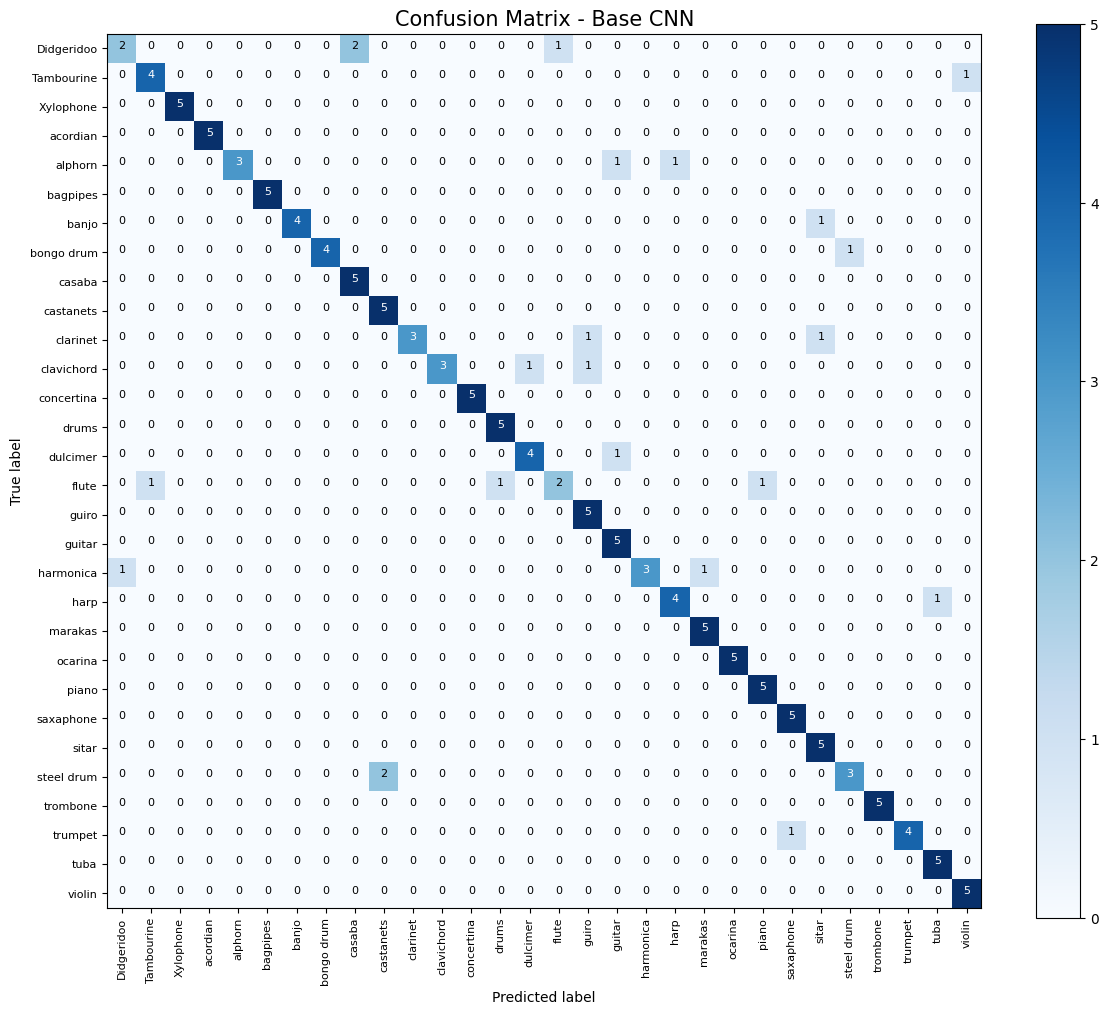

Model saved to /content/MIC-MA1/experiments/base_cnn_20250430_085509/base_cnn.pt
Model saved to /content/MIC-MA1/experiments/base_cnn_20250430_085509/base_cnn.pt


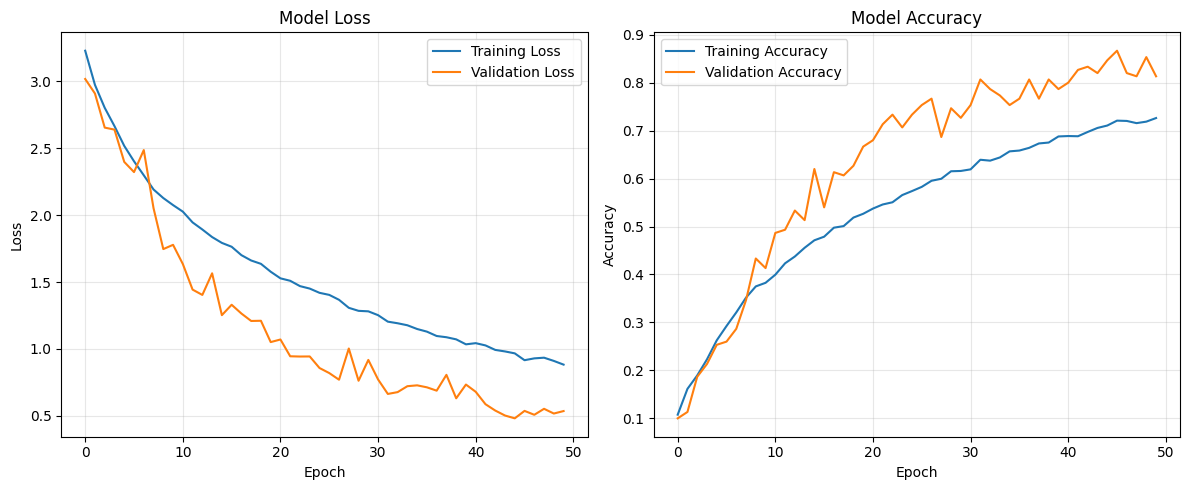


Increased batch size to 64 for Deeper CNN

Training model with DataParallel: Deeper CNN
Epoch 1/50
----------


train Epoch 1/50:   0%|          | 0/150 [00:00<?, ?it/s]

train Loss: 3.3029 Acc: 0.0720


val Epoch 1/50:   0%|          | 0/5 [00:00<?, ?it/s]

val Loss: 3.4454 Acc: 0.0867
New best model found! Val accuracy: 0.0867

Epoch 2/50
----------


train Epoch 2/50:   0%|          | 0/150 [00:00<?, ?it/s]

train Loss: 3.1217 Acc: 0.1152


val Epoch 2/50:   0%|          | 0/5 [00:00<?, ?it/s]

val Loss: 3.0557 Acc: 0.1133
New best model found! Val accuracy: 0.1133

Epoch 3/50
----------


train Epoch 3/50:   0%|          | 0/150 [00:00<?, ?it/s]

train Loss: 2.9637 Acc: 0.1573


val Epoch 3/50:   0%|          | 0/5 [00:00<?, ?it/s]

val Loss: 2.8204 Acc: 0.1800
New best model found! Val accuracy: 0.1800

Epoch 4/50
----------


train Epoch 4/50:   0%|          | 0/150 [00:00<?, ?it/s]

train Loss: 2.7591 Acc: 0.2076


val Epoch 4/50:   0%|          | 0/5 [00:00<?, ?it/s]

val Loss: 2.5940 Acc: 0.1867
New best model found! Val accuracy: 0.1867

Epoch 5/50
----------


train Epoch 5/50:   0%|          | 0/150 [00:00<?, ?it/s]

train Loss: 2.6025 Acc: 0.2349


val Epoch 5/50:   0%|          | 0/5 [00:00<?, ?it/s]

val Loss: 2.1695 Acc: 0.3200
New best model found! Val accuracy: 0.3200

Epoch 6/50
----------


train Epoch 6/50:   0%|          | 0/150 [00:00<?, ?it/s]

train Loss: 2.4581 Acc: 0.2744


val Epoch 6/50:   0%|          | 0/5 [00:00<?, ?it/s]

val Loss: 2.1609 Acc: 0.2933

Epoch 7/50
----------


train Epoch 7/50:   0%|          | 0/150 [00:00<?, ?it/s]

train Loss: 2.3563 Acc: 0.3050


val Epoch 7/50:   0%|          | 0/5 [00:00<?, ?it/s]

val Loss: 2.5258 Acc: 0.3067

Epoch 8/50
----------


train Epoch 8/50:   0%|          | 0/150 [00:00<?, ?it/s]

train Loss: 2.2275 Acc: 0.3395


val Epoch 8/50:   0%|          | 0/5 [00:00<?, ?it/s]

val Loss: 1.9841 Acc: 0.4067
New best model found! Val accuracy: 0.4067

Epoch 9/50
----------


train Epoch 9/50:   0%|          | 0/150 [00:00<?, ?it/s]

train Loss: 2.1525 Acc: 0.3662


val Epoch 9/50:   0%|          | 0/5 [00:00<?, ?it/s]

val Loss: 1.5334 Acc: 0.4867
New best model found! Val accuracy: 0.4867

Epoch 10/50
----------


train Epoch 10/50:   0%|          | 0/150 [00:00<?, ?it/s]

train Loss: 2.1110 Acc: 0.3741


val Epoch 10/50:   0%|          | 0/5 [00:00<?, ?it/s]

val Loss: 1.9039 Acc: 0.3867

Epoch 11/50
----------


train Epoch 11/50:   0%|          | 0/150 [00:00<?, ?it/s]

train Loss: 2.0186 Acc: 0.4100


val Epoch 11/50:   0%|          | 0/5 [00:00<?, ?it/s]

val Loss: 1.7531 Acc: 0.4800

Epoch 12/50
----------


train Epoch 12/50:   0%|          | 0/150 [00:00<?, ?it/s]

train Loss: 1.9438 Acc: 0.4158


val Epoch 12/50:   0%|          | 0/5 [00:00<?, ?it/s]

val Loss: 1.4205 Acc: 0.4867

Epoch 13/50
----------


train Epoch 13/50:   0%|          | 0/150 [00:00<?, ?it/s]

train Loss: 1.9060 Acc: 0.4325


val Epoch 13/50:   0%|          | 0/5 [00:00<?, ?it/s]

val Loss: 1.6041 Acc: 0.5000
New best model found! Val accuracy: 0.5000

Epoch 14/50
----------


train Epoch 14/50:   0%|          | 0/150 [00:00<?, ?it/s]

train Loss: 1.8358 Acc: 0.4461


val Epoch 14/50:   0%|          | 0/5 [00:00<?, ?it/s]

val Loss: 1.3279 Acc: 0.5200
New best model found! Val accuracy: 0.5200

Epoch 15/50
----------


train Epoch 15/50:   0%|          | 0/150 [00:00<?, ?it/s]

train Loss: 1.8230 Acc: 0.4521


val Epoch 15/50:   0%|          | 0/5 [00:00<?, ?it/s]

val Loss: 1.5171 Acc: 0.5400
New best model found! Val accuracy: 0.5400

Epoch 16/50
----------


train Epoch 16/50:   0%|          | 0/150 [00:00<?, ?it/s]

train Loss: 1.7520 Acc: 0.4749


val Epoch 16/50:   0%|          | 0/5 [00:00<?, ?it/s]

val Loss: 1.2641 Acc: 0.6200
New best model found! Val accuracy: 0.6200

Epoch 17/50
----------


train Epoch 17/50:   0%|          | 0/150 [00:00<?, ?it/s]

train Loss: 1.7013 Acc: 0.4976


val Epoch 17/50:   0%|          | 0/5 [00:00<?, ?it/s]

val Loss: 1.1253 Acc: 0.6400
New best model found! Val accuracy: 0.6400

Epoch 18/50
----------


train Epoch 18/50:   0%|          | 0/150 [00:00<?, ?it/s]

train Loss: 1.6197 Acc: 0.5168


val Epoch 18/50:   0%|          | 0/5 [00:00<?, ?it/s]

val Loss: 0.9708 Acc: 0.6333

Epoch 19/50
----------


train Epoch 19/50:   0%|          | 0/150 [00:00<?, ?it/s]

train Loss: 1.6380 Acc: 0.5039


val Epoch 19/50:   0%|          | 0/5 [00:00<?, ?it/s]

val Loss: 0.9806 Acc: 0.6800
New best model found! Val accuracy: 0.6800

Epoch 20/50
----------


train Epoch 20/50:   0%|          | 0/150 [00:00<?, ?it/s]

train Loss: 1.5699 Acc: 0.5199


val Epoch 20/50:   0%|          | 0/5 [00:00<?, ?it/s]

val Loss: 0.9873 Acc: 0.6667

Epoch 21/50
----------


train Epoch 21/50:   0%|          | 0/150 [00:00<?, ?it/s]

train Loss: 1.5350 Acc: 0.5422


val Epoch 21/50:   0%|          | 0/5 [00:00<?, ?it/s]

val Loss: 1.0151 Acc: 0.6533

Epoch 22/50
----------


train Epoch 22/50:   0%|          | 0/150 [00:00<?, ?it/s]

train Loss: 1.5266 Acc: 0.5404


val Epoch 22/50:   0%|          | 0/5 [00:00<?, ?it/s]

val Loss: 0.8330 Acc: 0.7333
New best model found! Val accuracy: 0.7333

Epoch 23/50
----------


train Epoch 23/50:   0%|          | 0/150 [00:00<?, ?it/s]

train Loss: 1.4715 Acc: 0.5594


val Epoch 23/50:   0%|          | 0/5 [00:00<?, ?it/s]

val Loss: 0.9049 Acc: 0.6933

Epoch 24/50
----------


train Epoch 24/50:   0%|          | 0/150 [00:00<?, ?it/s]

train Loss: 1.4195 Acc: 0.5675


val Epoch 24/50:   0%|          | 0/5 [00:00<?, ?it/s]

val Loss: 0.8296 Acc: 0.6800

Epoch 25/50
----------


train Epoch 25/50:   0%|          | 0/150 [00:00<?, ?it/s]

train Loss: 1.3955 Acc: 0.5827


val Epoch 25/50:   0%|          | 0/5 [00:00<?, ?it/s]

val Loss: 0.7290 Acc: 0.7200

Epoch 26/50
----------


train Epoch 26/50:   0%|          | 0/150 [00:00<?, ?it/s]

train Loss: 1.3706 Acc: 0.5892


val Epoch 26/50:   0%|          | 0/5 [00:00<?, ?it/s]

val Loss: 0.7287 Acc: 0.7333

Epoch 27/50
----------


train Epoch 27/50:   0%|          | 0/150 [00:00<?, ?it/s]

train Loss: 1.3690 Acc: 0.5902


val Epoch 27/50:   0%|          | 0/5 [00:00<?, ?it/s]

val Loss: 0.6225 Acc: 0.7867
New best model found! Val accuracy: 0.7867

Epoch 28/50
----------


train Epoch 28/50:   0%|          | 0/150 [00:00<?, ?it/s]

train Loss: 1.3092 Acc: 0.6013


val Epoch 28/50:   0%|          | 0/5 [00:00<?, ?it/s]

val Loss: 0.7090 Acc: 0.7667

Epoch 29/50
----------


train Epoch 29/50:   0%|          | 0/150 [00:00<?, ?it/s]

train Loss: 1.2873 Acc: 0.6138


val Epoch 29/50:   0%|          | 0/5 [00:00<?, ?it/s]

val Loss: 0.6786 Acc: 0.7733

Epoch 30/50
----------


train Epoch 30/50:   0%|          | 0/150 [00:00<?, ?it/s]

train Loss: 1.2727 Acc: 0.6126


val Epoch 30/50:   0%|          | 0/5 [00:00<?, ?it/s]

val Loss: 0.6245 Acc: 0.7867

Epoch 31/50
----------


train Epoch 31/50:   0%|          | 0/150 [00:00<?, ?it/s]

train Loss: 1.2093 Acc: 0.6318


val Epoch 31/50:   0%|          | 0/5 [00:00<?, ?it/s]

val Loss: 0.7416 Acc: 0.7467

Epoch 32/50
----------


train Epoch 32/50:   0%|          | 0/150 [00:00<?, ?it/s]

train Loss: 1.2075 Acc: 0.6366


val Epoch 32/50:   0%|          | 0/5 [00:00<?, ?it/s]

val Loss: 0.7551 Acc: 0.7533

Epoch 33/50
----------


train Epoch 33/50:   0%|          | 0/150 [00:00<?, ?it/s]

train Loss: 1.1756 Acc: 0.6359


val Epoch 33/50:   0%|          | 0/5 [00:00<?, ?it/s]

val Loss: 0.5649 Acc: 0.8000
New best model found! Val accuracy: 0.8000

Epoch 34/50
----------


train Epoch 34/50:   0%|          | 0/150 [00:00<?, ?it/s]

train Loss: 1.1452 Acc: 0.6589


val Epoch 34/50:   0%|          | 0/5 [00:00<?, ?it/s]

val Loss: 0.7228 Acc: 0.7600

Epoch 35/50
----------


train Epoch 35/50:   0%|          | 0/150 [00:00<?, ?it/s]

train Loss: 1.1216 Acc: 0.6555


val Epoch 35/50:   0%|          | 0/5 [00:00<?, ?it/s]

val Loss: 0.5765 Acc: 0.7733

Epoch 36/50
----------


train Epoch 36/50:   0%|          | 0/150 [00:00<?, ?it/s]

train Loss: 1.1036 Acc: 0.6628


val Epoch 36/50:   0%|          | 0/5 [00:00<?, ?it/s]

val Loss: 0.5151 Acc: 0.8200
New best model found! Val accuracy: 0.8200

Epoch 37/50
----------


train Epoch 37/50:   0%|          | 0/150 [00:00<?, ?it/s]

train Loss: 1.0680 Acc: 0.6693


val Epoch 37/50:   0%|          | 0/5 [00:00<?, ?it/s]

val Loss: 0.7882 Acc: 0.7533

Epoch 38/50
----------


train Epoch 38/50:   0%|          | 0/150 [00:00<?, ?it/s]

train Loss: 1.0583 Acc: 0.6802


val Epoch 38/50:   0%|          | 0/5 [00:00<?, ?it/s]

val Loss: 0.5642 Acc: 0.8000

Epoch 39/50
----------


train Epoch 39/50:   0%|          | 0/150 [00:00<?, ?it/s]

train Loss: 1.0426 Acc: 0.6966


val Epoch 39/50:   0%|          | 0/5 [00:00<?, ?it/s]

val Loss: 0.5094 Acc: 0.8267
New best model found! Val accuracy: 0.8267

Epoch 40/50
----------


train Epoch 40/50:   0%|          | 0/150 [00:00<?, ?it/s]

train Loss: 1.0092 Acc: 0.6847


val Epoch 40/50:   0%|          | 0/5 [00:00<?, ?it/s]

val Loss: 0.5396 Acc: 0.8200

Epoch 41/50
----------


train Epoch 41/50:   0%|          | 0/150 [00:00<?, ?it/s]

train Loss: 1.0021 Acc: 0.6948


val Epoch 41/50:   0%|          | 0/5 [00:00<?, ?it/s]

val Loss: 0.4710 Acc: 0.8533
New best model found! Val accuracy: 0.8533

Epoch 42/50
----------


train Epoch 42/50:   0%|          | 0/150 [00:00<?, ?it/s]

train Loss: 0.9513 Acc: 0.7115


val Epoch 42/50:   0%|          | 0/5 [00:00<?, ?it/s]

val Loss: 0.4777 Acc: 0.8400

Epoch 43/50
----------


train Epoch 43/50:   0%|          | 0/150 [00:00<?, ?it/s]

train Loss: 0.9639 Acc: 0.7052


val Epoch 43/50:   0%|          | 0/5 [00:00<?, ?it/s]

val Loss: 0.5659 Acc: 0.8200

Epoch 44/50
----------


train Epoch 44/50:   0%|          | 0/150 [00:00<?, ?it/s]

train Loss: 0.9238 Acc: 0.7156


val Epoch 44/50:   0%|          | 0/5 [00:00<?, ?it/s]

val Loss: 0.3858 Acc: 0.8667
New best model found! Val accuracy: 0.8667

Epoch 45/50
----------


train Epoch 45/50:   0%|          | 0/150 [00:00<?, ?it/s]

train Loss: 0.9034 Acc: 0.7229


val Epoch 45/50:   0%|          | 0/5 [00:00<?, ?it/s]

val Loss: 0.3353 Acc: 0.8800
New best model found! Val accuracy: 0.8800

Epoch 46/50
----------


train Epoch 46/50:   0%|          | 0/150 [00:00<?, ?it/s]

train Loss: 0.8634 Acc: 0.7342


val Epoch 46/50:   0%|          | 0/5 [00:00<?, ?it/s]

val Loss: 0.3622 Acc: 0.8800

Epoch 47/50
----------


train Epoch 47/50:   0%|          | 0/150 [00:00<?, ?it/s]

train Loss: 0.8796 Acc: 0.7321


val Epoch 47/50:   0%|          | 0/5 [00:00<?, ?it/s]

val Loss: 0.3399 Acc: 0.9067
New best model found! Val accuracy: 0.9067

Epoch 48/50
----------


train Epoch 48/50:   0%|          | 0/150 [00:00<?, ?it/s]

train Loss: 0.8400 Acc: 0.7461


val Epoch 48/50:   0%|          | 0/5 [00:00<?, ?it/s]

val Loss: 0.3350 Acc: 0.9000

Epoch 49/50
----------


train Epoch 49/50:   0%|          | 0/150 [00:00<?, ?it/s]

train Loss: 0.8428 Acc: 0.7377


val Epoch 49/50:   0%|          | 0/5 [00:00<?, ?it/s]

val Loss: 0.4178 Acc: 0.8533

Epoch 50/50
----------


train Epoch 50/50:   0%|          | 0/150 [00:00<?, ?it/s]

train Loss: 0.8141 Acc: 0.7478


val Epoch 50/50:   0%|          | 0/5 [00:00<?, ?it/s]

val Loss: 0.3409 Acc: 0.8667

Training complete in 36m 4s
Best val Acc: 0.9067 at epoch 47

Evaluating model: Deeper CNN on test set


Evaluating:   0%|          | 0/5 [00:00<?, ?it/s]

Test Accuracy: 86.67%
Test Accuracy: 0.8667
Macro-average F1 Score: 0.8567
Macro-average Precision: 0.8935
Macro-average Recall: 0.8667


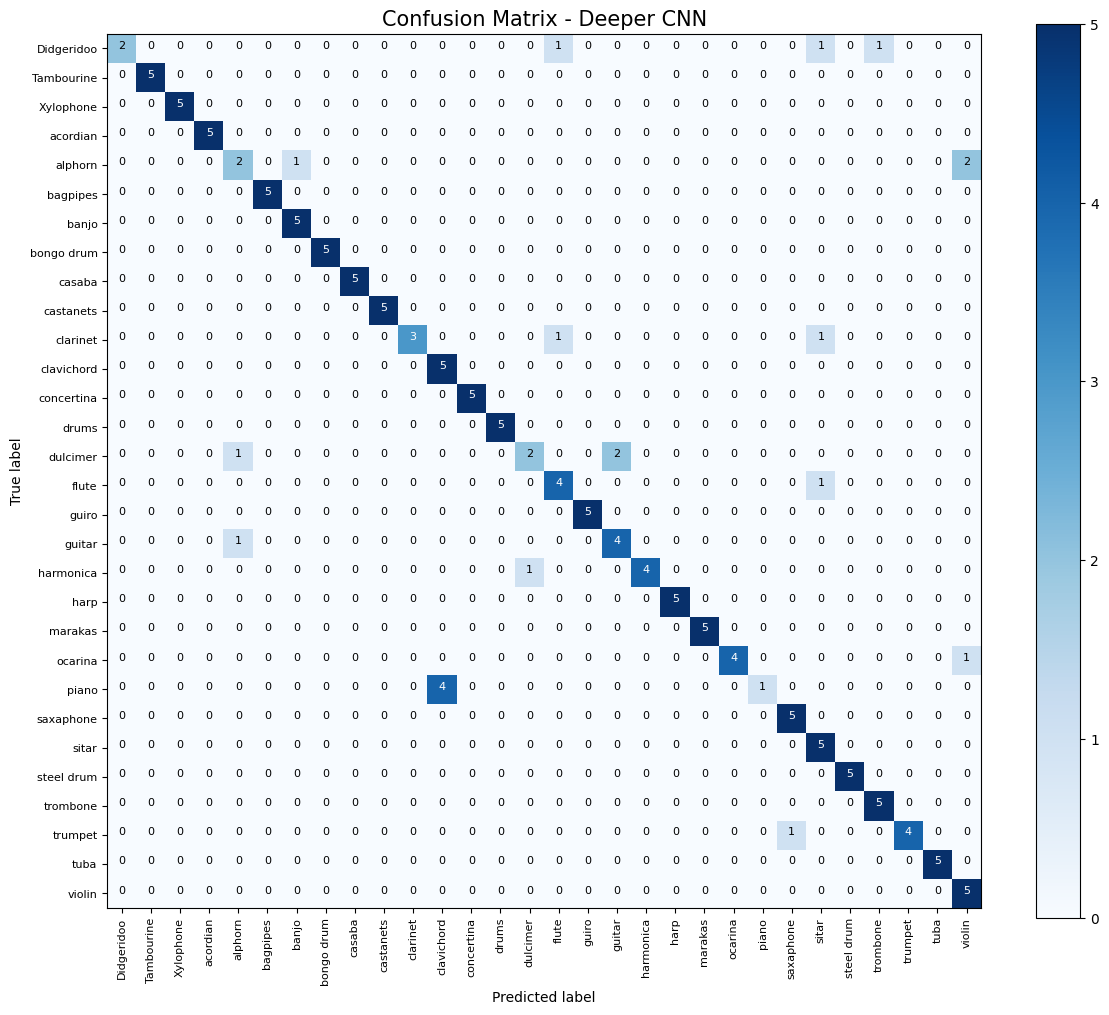

Model saved to /content/MIC-MA1/experiments/deeper_cnn_20250430_093116/deeper_cnn.pt
Model saved to /content/MIC-MA1/experiments/deeper_cnn_20250430_093116/deeper_cnn.pt


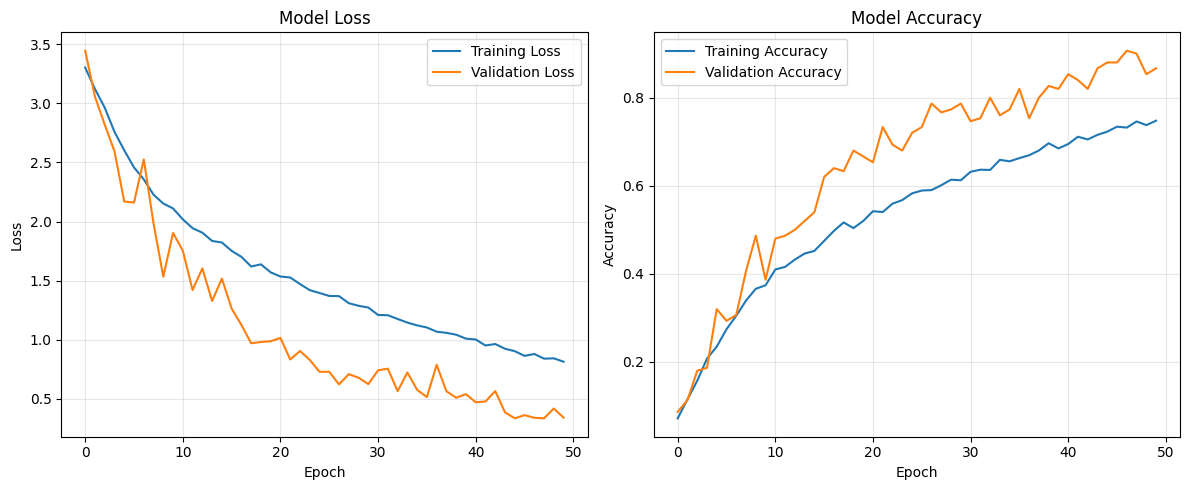


Increased batch size to 64 for Wider CNN

Training model with DataParallel: Wider CNN
Epoch 1/50
----------


train Epoch 1/50:   0%|          | 0/150 [00:00<?, ?it/s]

train Loss: 3.2957 Acc: 0.0724


val Epoch 1/50:   0%|          | 0/5 [00:00<?, ?it/s]

val Loss: 3.1204 Acc: 0.0533
New best model found! Val accuracy: 0.0533

Epoch 2/50
----------


train Epoch 2/50:   0%|          | 0/150 [00:00<?, ?it/s]

train Loss: 3.1836 Acc: 0.0885


val Epoch 2/50:   0%|          | 0/5 [00:00<?, ?it/s]

val Loss: 3.0575 Acc: 0.0867
New best model found! Val accuracy: 0.0867

Epoch 3/50
----------


train Epoch 3/50:   0%|          | 0/150 [00:00<?, ?it/s]

train Loss: 3.0567 Acc: 0.1168


val Epoch 3/50:   0%|          | 0/5 [00:00<?, ?it/s]

val Loss: 2.7637 Acc: 0.1533
New best model found! Val accuracy: 0.1533

Epoch 4/50
----------


train Epoch 4/50:   0%|          | 0/150 [00:00<?, ?it/s]

train Loss: 2.9769 Acc: 0.1314


val Epoch 4/50:   0%|          | 0/5 [00:00<?, ?it/s]

val Loss: 2.9276 Acc: 0.1400

Epoch 5/50
----------


train Epoch 5/50:   0%|          | 0/150 [00:00<?, ?it/s]

train Loss: 2.9177 Acc: 0.1417


val Epoch 5/50:   0%|          | 0/5 [00:00<?, ?it/s]

val Loss: 2.8480 Acc: 0.1267

Epoch 6/50
----------


train Epoch 6/50:   0%|          | 0/150 [00:00<?, ?it/s]

train Loss: 2.8449 Acc: 0.1525


val Epoch 6/50:   0%|          | 0/5 [00:00<?, ?it/s]

val Loss: 3.1132 Acc: 0.1000

Epoch 7/50
----------


train Epoch 7/50:   0%|          | 0/150 [00:00<?, ?it/s]

train Loss: 2.7961 Acc: 0.1640


val Epoch 7/50:   0%|          | 0/5 [00:00<?, ?it/s]

val Loss: 2.9319 Acc: 0.1333

Epoch 8/50
----------


train Epoch 8/50:   0%|          | 0/150 [00:00<?, ?it/s]

train Loss: 2.7490 Acc: 0.1865


val Epoch 8/50:   0%|          | 0/5 [00:00<?, ?it/s]

val Loss: 2.4639 Acc: 0.1933
New best model found! Val accuracy: 0.1933

Epoch 9/50
----------


train Epoch 9/50:   0%|          | 0/150 [00:00<?, ?it/s]

train Loss: 2.6493 Acc: 0.2201


val Epoch 9/50:   0%|          | 0/5 [00:00<?, ?it/s]

val Loss: 2.8802 Acc: 0.1533

Epoch 10/50
----------


train Epoch 10/50:   0%|          | 0/150 [00:00<?, ?it/s]

train Loss: 2.5792 Acc: 0.2343


val Epoch 10/50:   0%|          | 0/5 [00:00<?, ?it/s]

val Loss: 2.4573 Acc: 0.2467
New best model found! Val accuracy: 0.2467

Epoch 11/50
----------


train Epoch 11/50:   0%|          | 0/150 [00:00<?, ?it/s]

train Loss: 2.4698 Acc: 0.2623


val Epoch 11/50:   0%|          | 0/5 [00:00<?, ?it/s]

val Loss: 2.1192 Acc: 0.3200
New best model found! Val accuracy: 0.3200

Epoch 12/50
----------


train Epoch 12/50:   0%|          | 0/150 [00:00<?, ?it/s]

train Loss: 2.3881 Acc: 0.2885


val Epoch 12/50:   0%|          | 0/5 [00:00<?, ?it/s]

val Loss: 2.0809 Acc: 0.3333
New best model found! Val accuracy: 0.3333

Epoch 13/50
----------


train Epoch 13/50:   0%|          | 0/150 [00:00<?, ?it/s]

train Loss: 2.3230 Acc: 0.3077


val Epoch 13/50:   0%|          | 0/5 [00:00<?, ?it/s]

val Loss: 2.6526 Acc: 0.2733

Epoch 14/50
----------


train Epoch 14/50:   0%|          | 0/150 [00:00<?, ?it/s]

train Loss: 2.2479 Acc: 0.3178


val Epoch 14/50:   0%|          | 0/5 [00:00<?, ?it/s]

val Loss: 2.5036 Acc: 0.2800

Epoch 15/50
----------


train Epoch 15/50:   0%|          | 0/150 [00:00<?, ?it/s]

train Loss: 2.1903 Acc: 0.3524


val Epoch 15/50:   0%|          | 0/5 [00:00<?, ?it/s]

val Loss: 2.3214 Acc: 0.2667

Epoch 16/50
----------


train Epoch 16/50:   0%|          | 0/150 [00:00<?, ?it/s]

train Loss: 2.1584 Acc: 0.3513


val Epoch 16/50:   0%|          | 0/5 [00:00<?, ?it/s]

val Loss: 1.7859 Acc: 0.4000
New best model found! Val accuracy: 0.4000

Epoch 17/50
----------


train Epoch 17/50:   0%|          | 0/150 [00:00<?, ?it/s]

train Loss: 2.0889 Acc: 0.3770


val Epoch 17/50:   0%|          | 0/5 [00:00<?, ?it/s]

val Loss: 1.6387 Acc: 0.4267
New best model found! Val accuracy: 0.4267

Epoch 18/50
----------


train Epoch 18/50:   0%|          | 0/150 [00:00<?, ?it/s]

train Loss: 2.0244 Acc: 0.3864


val Epoch 18/50:   0%|          | 0/5 [00:00<?, ?it/s]

val Loss: 1.6149 Acc: 0.4467
New best model found! Val accuracy: 0.4467

Epoch 19/50
----------


train Epoch 19/50:   0%|          | 0/150 [00:00<?, ?it/s]

train Loss: 1.9861 Acc: 0.3977


val Epoch 19/50:   0%|          | 0/5 [00:00<?, ?it/s]

val Loss: 1.6859 Acc: 0.3800

Epoch 20/50
----------


train Epoch 20/50:   0%|          | 0/150 [00:00<?, ?it/s]

train Loss: 1.9527 Acc: 0.4119


val Epoch 20/50:   0%|          | 0/5 [00:00<?, ?it/s]

val Loss: 1.3847 Acc: 0.5200
New best model found! Val accuracy: 0.5200

Epoch 21/50
----------


train Epoch 21/50:   0%|          | 0/150 [00:00<?, ?it/s]

train Loss: 1.9104 Acc: 0.4244


val Epoch 21/50:   0%|          | 0/5 [00:00<?, ?it/s]

val Loss: 1.7286 Acc: 0.4800

Epoch 22/50
----------


train Epoch 22/50:   0%|          | 0/150 [00:00<?, ?it/s]

train Loss: 1.8655 Acc: 0.4283


val Epoch 22/50:   0%|          | 0/5 [00:00<?, ?it/s]

val Loss: 1.8108 Acc: 0.4200

Epoch 23/50
----------


train Epoch 23/50:   0%|          | 0/150 [00:00<?, ?it/s]

train Loss: 1.8620 Acc: 0.4325


val Epoch 23/50:   0%|          | 0/5 [00:00<?, ?it/s]

val Loss: 1.8038 Acc: 0.4533

Epoch 24/50
----------


train Epoch 24/50:   0%|          | 0/150 [00:00<?, ?it/s]

train Loss: 1.8270 Acc: 0.4448


val Epoch 24/50:   0%|          | 0/5 [00:00<?, ?it/s]

val Loss: 1.3644 Acc: 0.5533
New best model found! Val accuracy: 0.5533

Epoch 25/50
----------


train Epoch 25/50:   0%|          | 0/150 [00:00<?, ?it/s]

train Loss: 1.8227 Acc: 0.4463


val Epoch 25/50:   0%|          | 0/5 [00:00<?, ?it/s]

val Loss: 1.6564 Acc: 0.4467

Epoch 26/50
----------


train Epoch 26/50:   0%|          | 0/150 [00:00<?, ?it/s]

train Loss: 1.7240 Acc: 0.4740


val Epoch 26/50:   0%|          | 0/5 [00:00<?, ?it/s]

val Loss: 1.1961 Acc: 0.6200
New best model found! Val accuracy: 0.6200

Epoch 27/50
----------


train Epoch 27/50:   0%|          | 0/150 [00:00<?, ?it/s]

train Loss: 1.7642 Acc: 0.4665


val Epoch 27/50:   0%|          | 0/5 [00:00<?, ?it/s]

val Loss: 1.5312 Acc: 0.5400

Epoch 28/50
----------


train Epoch 28/50:   0%|          | 0/150 [00:00<?, ?it/s]

train Loss: 1.7024 Acc: 0.4790


val Epoch 28/50:   0%|          | 0/5 [00:00<?, ?it/s]

val Loss: 1.4006 Acc: 0.5467

Epoch 29/50
----------


train Epoch 29/50:   0%|          | 0/150 [00:00<?, ?it/s]

train Loss: 1.7070 Acc: 0.4845


val Epoch 29/50:   0%|          | 0/5 [00:00<?, ?it/s]

val Loss: 1.4124 Acc: 0.5933

Epoch 30/50
----------


train Epoch 30/50:   0%|          | 0/150 [00:00<?, ?it/s]

train Loss: 1.6552 Acc: 0.5014


val Epoch 30/50:   0%|          | 0/5 [00:00<?, ?it/s]

val Loss: 1.2769 Acc: 0.5800

Epoch 31/50
----------


train Epoch 31/50:   0%|          | 0/150 [00:00<?, ?it/s]

train Loss: 1.6291 Acc: 0.4982


val Epoch 31/50:   0%|          | 0/5 [00:00<?, ?it/s]

val Loss: 1.0508 Acc: 0.6400
New best model found! Val accuracy: 0.6400

Epoch 32/50
----------


train Epoch 32/50:   0%|          | 0/150 [00:00<?, ?it/s]

train Loss: 1.6062 Acc: 0.5103


val Epoch 32/50:   0%|          | 0/5 [00:00<?, ?it/s]

val Loss: 1.2237 Acc: 0.5933

Epoch 33/50
----------


train Epoch 33/50:   0%|          | 0/150 [00:00<?, ?it/s]

train Loss: 1.5816 Acc: 0.5120


val Epoch 33/50:   0%|          | 0/5 [00:00<?, ?it/s]

val Loss: 1.0905 Acc: 0.6333

Epoch 34/50
----------


train Epoch 34/50:   0%|          | 0/150 [00:00<?, ?it/s]

train Loss: 1.5465 Acc: 0.5220


val Epoch 34/50:   0%|          | 0/5 [00:00<?, ?it/s]

val Loss: 1.1140 Acc: 0.6333

Epoch 35/50
----------


train Epoch 35/50:   0%|          | 0/150 [00:00<?, ?it/s]

train Loss: 1.5695 Acc: 0.5193


val Epoch 35/50:   0%|          | 0/5 [00:00<?, ?it/s]

val Loss: 0.9085 Acc: 0.7267
New best model found! Val accuracy: 0.7267

Epoch 36/50
----------


train Epoch 36/50:   0%|          | 0/150 [00:00<?, ?it/s]

train Loss: 1.5317 Acc: 0.5329


val Epoch 36/50:   0%|          | 0/5 [00:00<?, ?it/s]

val Loss: 1.0128 Acc: 0.6533

Epoch 37/50
----------


train Epoch 37/50:   0%|          | 0/150 [00:00<?, ?it/s]

train Loss: 1.4980 Acc: 0.5454


val Epoch 37/50:   0%|          | 0/5 [00:00<?, ?it/s]

val Loss: 1.0057 Acc: 0.6667

Epoch 38/50
----------


train Epoch 38/50:   0%|          | 0/150 [00:00<?, ?it/s]

train Loss: 1.4758 Acc: 0.5458


val Epoch 38/50:   0%|          | 0/5 [00:00<?, ?it/s]

val Loss: 1.2002 Acc: 0.6200

Epoch 39/50
----------


train Epoch 39/50:   0%|          | 0/150 [00:00<?, ?it/s]

train Loss: 1.4515 Acc: 0.5577


val Epoch 39/50:   0%|          | 0/5 [00:00<?, ?it/s]

val Loss: 0.8719 Acc: 0.7200

Epoch 40/50
----------


train Epoch 40/50:   0%|          | 0/150 [00:00<?, ?it/s]

train Loss: 1.4402 Acc: 0.5710


val Epoch 40/50:   0%|          | 0/5 [00:00<?, ?it/s]

val Loss: 0.9890 Acc: 0.6800

Epoch 41/50
----------


train Epoch 41/50:   0%|          | 0/150 [00:00<?, ?it/s]

train Loss: 1.4269 Acc: 0.5591


val Epoch 41/50:   0%|          | 0/5 [00:00<?, ?it/s]

val Loss: 0.8804 Acc: 0.6933

Epoch 42/50
----------


train Epoch 42/50:   0%|          | 0/150 [00:00<?, ?it/s]

train Loss: 1.3821 Acc: 0.5779


val Epoch 42/50:   0%|          | 0/5 [00:00<?, ?it/s]

val Loss: 0.8204 Acc: 0.7200

Epoch 43/50
----------


train Epoch 43/50:   0%|          | 0/150 [00:00<?, ?it/s]

train Loss: 1.3801 Acc: 0.5771


val Epoch 43/50:   0%|          | 0/5 [00:00<?, ?it/s]

val Loss: 0.9710 Acc: 0.6667

Epoch 44/50
----------


train Epoch 44/50:   0%|          | 0/150 [00:00<?, ?it/s]

train Loss: 1.3804 Acc: 0.5750


val Epoch 44/50:   0%|          | 0/5 [00:00<?, ?it/s]

val Loss: 0.9604 Acc: 0.6867

Epoch 45/50
----------


train Epoch 45/50:   0%|          | 0/150 [00:00<?, ?it/s]

train Loss: 1.3253 Acc: 0.5946


val Epoch 45/50:   0%|          | 0/5 [00:00<?, ?it/s]

val Loss: 0.8623 Acc: 0.7267

Epoch 46/50
----------


train Epoch 46/50:   0%|          | 0/150 [00:00<?, ?it/s]

train Loss: 1.3118 Acc: 0.6017


val Epoch 46/50:   0%|          | 0/5 [00:00<?, ?it/s]

val Loss: 0.7877 Acc: 0.7467
New best model found! Val accuracy: 0.7467

Epoch 47/50
----------


train Epoch 47/50:   0%|          | 0/150 [00:00<?, ?it/s]

train Loss: 1.3250 Acc: 0.5929


val Epoch 47/50:   0%|          | 0/5 [00:00<?, ?it/s]

val Loss: 0.7107 Acc: 0.7533
New best model found! Val accuracy: 0.7533

Epoch 48/50
----------


train Epoch 48/50:   0%|          | 0/150 [00:00<?, ?it/s]

train Loss: 1.3122 Acc: 0.6036


val Epoch 48/50:   0%|          | 0/5 [00:00<?, ?it/s]

val Loss: 0.7343 Acc: 0.7600
New best model found! Val accuracy: 0.7600

Epoch 49/50
----------


train Epoch 49/50:   0%|          | 0/150 [00:00<?, ?it/s]

train Loss: 1.3003 Acc: 0.6078


val Epoch 49/50:   0%|          | 0/5 [00:00<?, ?it/s]

val Loss: 0.8083 Acc: 0.7400

Epoch 50/50
----------


train Epoch 50/50:   0%|          | 0/150 [00:00<?, ?it/s]

train Loss: 1.2441 Acc: 0.6222


val Epoch 50/50:   0%|          | 0/5 [00:00<?, ?it/s]

val Loss: 0.6798 Acc: 0.7667
New best model found! Val accuracy: 0.7667

Training complete in 62m 17s
Best val Acc: 0.7667 at epoch 50

Evaluating model: Wider CNN on test set


Evaluating:   0%|          | 0/5 [00:00<?, ?it/s]

Test Accuracy: 80.67%
Test Accuracy: 0.8067
Macro-average F1 Score: 0.7973
Macro-average Precision: 0.8519
Macro-average Recall: 0.8067


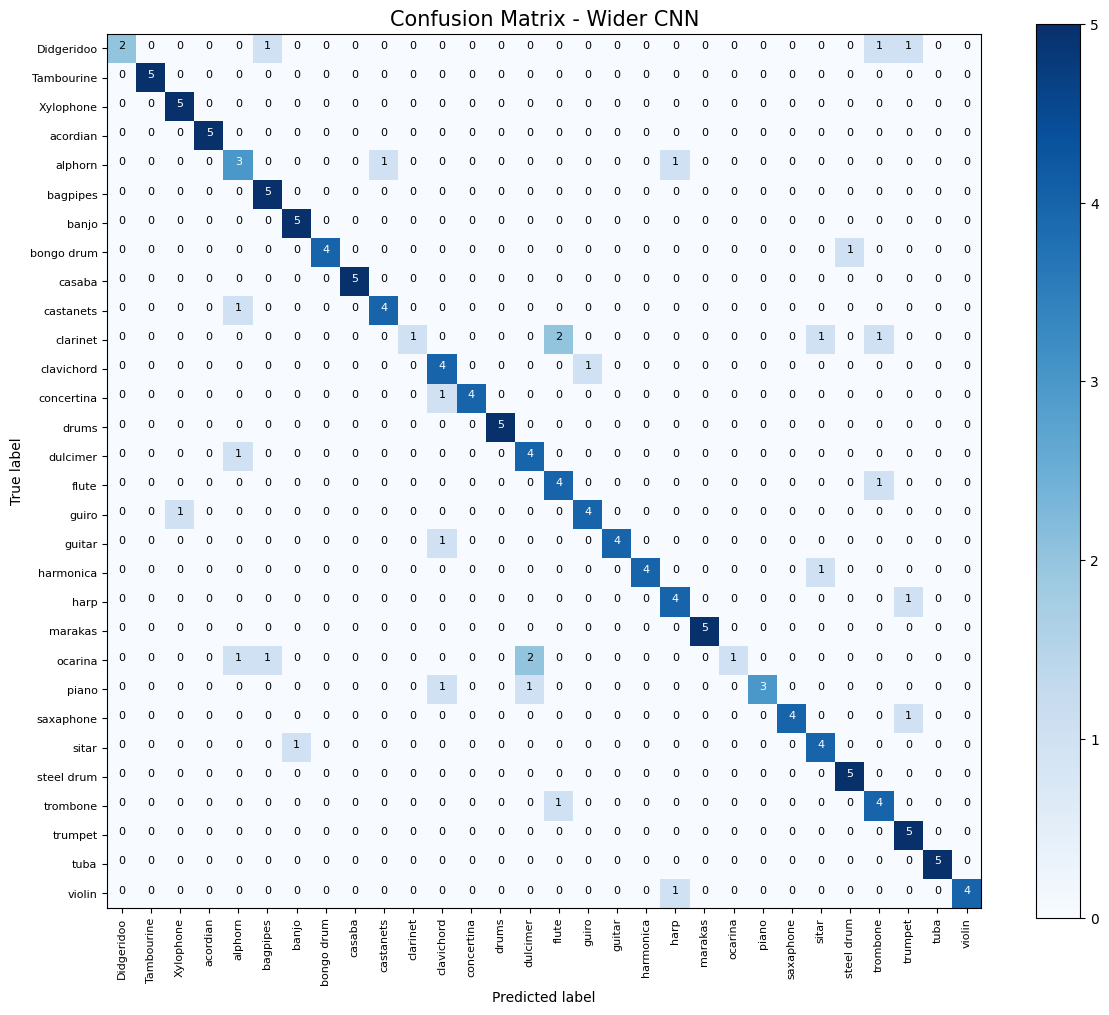

Model saved to /content/MIC-MA1/experiments/wider_cnn_20250430_103336/wider_cnn.pt
Model saved to /content/MIC-MA1/experiments/wider_cnn_20250430_103336/wider_cnn.pt


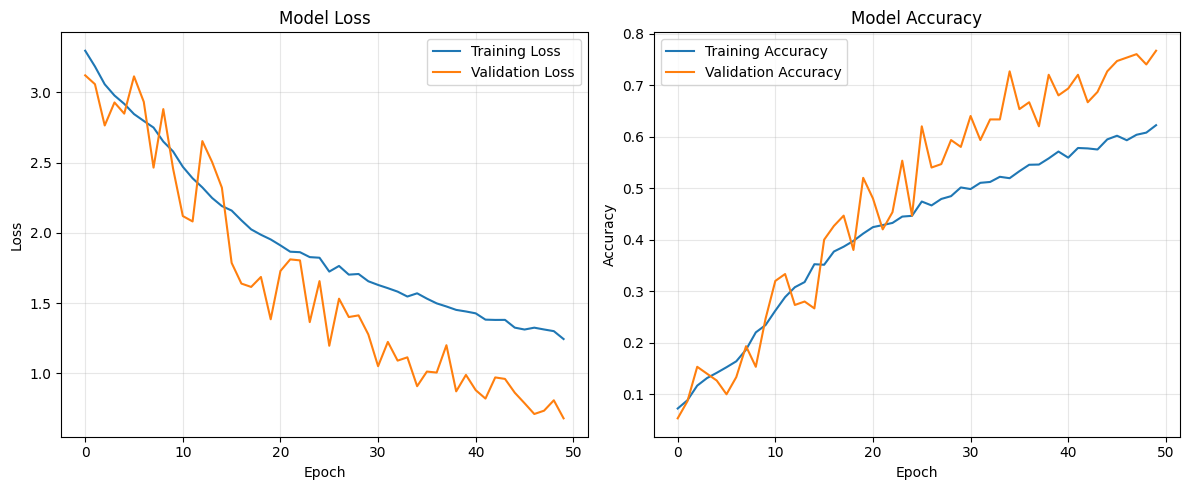


Increased batch size to 64 for Regularized CNN

Training model with DataParallel: Regularized CNN
Epoch 1/50
----------


train Epoch 1/50:   0%|          | 0/150 [00:00<?, ?it/s]

train Loss: 3.2738 Acc: 0.0933


val Epoch 1/50:   0%|          | 0/5 [00:00<?, ?it/s]

val Loss: 3.0909 Acc: 0.1000
New best model found! Val accuracy: 0.1000

Epoch 2/50
----------


train Epoch 2/50:   0%|          | 0/150 [00:00<?, ?it/s]

train Loss: 3.1114 Acc: 0.1235


val Epoch 2/50:   0%|          | 0/5 [00:00<?, ?it/s]

val Loss: 3.0313 Acc: 0.1333
New best model found! Val accuracy: 0.1333

Epoch 3/50
----------


train Epoch 3/50:   0%|          | 0/150 [00:00<?, ?it/s]

train Loss: 2.9842 Acc: 0.1467


val Epoch 3/50:   0%|          | 0/5 [00:00<?, ?it/s]

val Loss: 3.0097 Acc: 0.1467
New best model found! Val accuracy: 0.1467

Epoch 4/50
----------


train Epoch 4/50:   0%|          | 0/150 [00:00<?, ?it/s]

train Loss: 2.8816 Acc: 0.1717


val Epoch 4/50:   0%|          | 0/5 [00:00<?, ?it/s]

val Loss: 3.0405 Acc: 0.1467

Epoch 5/50
----------


train Epoch 5/50:   0%|          | 0/150 [00:00<?, ?it/s]

train Loss: 2.7535 Acc: 0.1936


val Epoch 5/50:   0%|          | 0/5 [00:00<?, ?it/s]

val Loss: 2.5617 Acc: 0.1933
New best model found! Val accuracy: 0.1933

Epoch 6/50
----------


train Epoch 6/50:   0%|          | 0/150 [00:00<?, ?it/s]

train Loss: 2.6746 Acc: 0.2047


val Epoch 6/50:   0%|          | 0/5 [00:00<?, ?it/s]

val Loss: 2.8342 Acc: 0.1733

Epoch 7/50
----------


train Epoch 7/50:   0%|          | 0/150 [00:00<?, ?it/s]

train Loss: 2.6195 Acc: 0.2172


val Epoch 7/50:   0%|          | 0/5 [00:00<?, ?it/s]

val Loss: 2.6949 Acc: 0.1733

Epoch 8/50
----------


train Epoch 8/50:   0%|          | 0/150 [00:00<?, ?it/s]

train Loss: 2.5389 Acc: 0.2397


val Epoch 8/50:   0%|          | 0/5 [00:00<?, ?it/s]

val Loss: 2.1861 Acc: 0.3067
New best model found! Val accuracy: 0.3067

Epoch 9/50
----------


train Epoch 9/50:   0%|          | 0/150 [00:00<?, ?it/s]

train Loss: 2.4490 Acc: 0.2570


val Epoch 9/50:   0%|          | 0/5 [00:00<?, ?it/s]

val Loss: 2.5829 Acc: 0.2000

Epoch 10/50
----------


train Epoch 10/50:   0%|          | 0/150 [00:00<?, ?it/s]

train Loss: 2.3987 Acc: 0.2698


val Epoch 10/50:   0%|          | 0/5 [00:00<?, ?it/s]

val Loss: 2.1504 Acc: 0.2933

Epoch 11/50
----------


train Epoch 11/50:   0%|          | 0/150 [00:00<?, ?it/s]

train Loss: 2.3121 Acc: 0.2975


val Epoch 11/50:   0%|          | 0/5 [00:00<?, ?it/s]

val Loss: 2.2635 Acc: 0.2667

Epoch 12/50
----------


train Epoch 12/50:   0%|          | 0/150 [00:00<?, ?it/s]

train Loss: 2.2846 Acc: 0.3167


val Epoch 12/50:   0%|          | 0/5 [00:00<?, ?it/s]

val Loss: 1.8179 Acc: 0.3667
New best model found! Val accuracy: 0.3667

Epoch 13/50
----------


train Epoch 13/50:   0%|          | 0/150 [00:00<?, ?it/s]

train Loss: 2.2100 Acc: 0.3397


val Epoch 13/50:   0%|          | 0/5 [00:00<?, ?it/s]

val Loss: 1.9454 Acc: 0.3867
New best model found! Val accuracy: 0.3867

Epoch 14/50
----------


train Epoch 14/50:   0%|          | 0/150 [00:00<?, ?it/s]

train Loss: 2.1549 Acc: 0.3453


val Epoch 14/50:   0%|          | 0/5 [00:00<?, ?it/s]

val Loss: 1.6363 Acc: 0.4600
New best model found! Val accuracy: 0.4600

Epoch 15/50
----------


train Epoch 15/50:   0%|          | 0/150 [00:00<?, ?it/s]

train Loss: 2.1092 Acc: 0.3724


val Epoch 15/50:   0%|          | 0/5 [00:00<?, ?it/s]

val Loss: 1.7764 Acc: 0.4533

Epoch 16/50
----------


train Epoch 16/50:   0%|          | 0/150 [00:00<?, ?it/s]

train Loss: 2.0370 Acc: 0.3860


val Epoch 16/50:   0%|          | 0/5 [00:00<?, ?it/s]

val Loss: 1.5581 Acc: 0.5200
New best model found! Val accuracy: 0.5200

Epoch 17/50
----------


train Epoch 17/50:   0%|          | 0/150 [00:00<?, ?it/s]

train Loss: 2.0474 Acc: 0.3872


val Epoch 17/50:   0%|          | 0/5 [00:00<?, ?it/s]

val Loss: 1.7626 Acc: 0.4133

Epoch 18/50
----------


train Epoch 18/50:   0%|          | 0/150 [00:00<?, ?it/s]

train Loss: 2.0029 Acc: 0.3970


val Epoch 18/50:   0%|          | 0/5 [00:00<?, ?it/s]

val Loss: 2.3102 Acc: 0.3600

Epoch 19/50
----------


train Epoch 19/50:   0%|          | 0/150 [00:00<?, ?it/s]

train Loss: 1.9680 Acc: 0.4048


val Epoch 19/50:   0%|          | 0/5 [00:00<?, ?it/s]

val Loss: 1.8133 Acc: 0.4733

Epoch 20/50
----------


train Epoch 20/50:   0%|          | 0/150 [00:00<?, ?it/s]

train Loss: 1.9309 Acc: 0.4254


val Epoch 20/50:   0%|          | 0/5 [00:00<?, ?it/s]

val Loss: 1.7171 Acc: 0.4933

Epoch 21/50
----------


train Epoch 21/50:   0%|          | 0/150 [00:00<?, ?it/s]

train Loss: 1.8819 Acc: 0.4475


val Epoch 21/50:   0%|          | 0/5 [00:00<?, ?it/s]

val Loss: 1.3830 Acc: 0.5400
New best model found! Val accuracy: 0.5400

Epoch 22/50
----------


train Epoch 22/50:   0%|          | 0/150 [00:00<?, ?it/s]

train Loss: 1.8635 Acc: 0.4431


val Epoch 22/50:   0%|          | 0/5 [00:00<?, ?it/s]

val Loss: 1.4808 Acc: 0.5000

Epoch 23/50
----------


train Epoch 23/50:   0%|          | 0/150 [00:00<?, ?it/s]

train Loss: 1.8211 Acc: 0.4544


val Epoch 23/50:   0%|          | 0/5 [00:00<?, ?it/s]

val Loss: 1.3103 Acc: 0.5600
New best model found! Val accuracy: 0.5600

Epoch 24/50
----------


train Epoch 24/50:   0%|          | 0/150 [00:00<?, ?it/s]

train Loss: 1.7837 Acc: 0.4573


val Epoch 24/50:   0%|          | 0/5 [00:00<?, ?it/s]

val Loss: 1.2028 Acc: 0.5800
New best model found! Val accuracy: 0.5800

Epoch 25/50
----------


train Epoch 25/50:   0%|          | 0/150 [00:00<?, ?it/s]

train Loss: 1.7908 Acc: 0.4661


val Epoch 25/50:   0%|          | 0/5 [00:00<?, ?it/s]

val Loss: 1.3543 Acc: 0.5867
New best model found! Val accuracy: 0.5867

Epoch 26/50
----------


train Epoch 26/50:   0%|          | 0/150 [00:00<?, ?it/s]

train Loss: 1.7617 Acc: 0.4705


val Epoch 26/50:   0%|          | 0/5 [00:00<?, ?it/s]

val Loss: 1.1509 Acc: 0.6067
New best model found! Val accuracy: 0.6067

Epoch 27/50
----------


train Epoch 27/50:   0%|          | 0/150 [00:00<?, ?it/s]

train Loss: 1.7207 Acc: 0.4799


val Epoch 27/50:   0%|          | 0/5 [00:00<?, ?it/s]

val Loss: 1.1257 Acc: 0.6533
New best model found! Val accuracy: 0.6533

Epoch 28/50
----------


train Epoch 28/50:   0%|          | 0/150 [00:00<?, ?it/s]

train Loss: 1.6873 Acc: 0.4953


val Epoch 28/50:   0%|          | 0/5 [00:00<?, ?it/s]

val Loss: 1.1619 Acc: 0.5800

Epoch 29/50
----------


train Epoch 29/50:   0%|          | 0/150 [00:00<?, ?it/s]

train Loss: 1.6646 Acc: 0.5011


val Epoch 29/50:   0%|          | 0/5 [00:00<?, ?it/s]

val Loss: 1.0325 Acc: 0.6733
New best model found! Val accuracy: 0.6733

Epoch 30/50
----------


train Epoch 30/50:   0%|          | 0/150 [00:00<?, ?it/s]

train Loss: 1.6419 Acc: 0.4961


val Epoch 30/50:   0%|          | 0/5 [00:00<?, ?it/s]

val Loss: 1.0097 Acc: 0.7000
New best model found! Val accuracy: 0.7000

Epoch 31/50
----------


train Epoch 31/50:   0%|          | 0/150 [00:00<?, ?it/s]

train Loss: 1.5943 Acc: 0.5143


val Epoch 31/50:   0%|          | 0/5 [00:00<?, ?it/s]

val Loss: 0.9924 Acc: 0.6667

Epoch 32/50
----------


train Epoch 32/50:   0%|          | 0/150 [00:00<?, ?it/s]

train Loss: 1.6051 Acc: 0.5160


val Epoch 32/50:   0%|          | 0/5 [00:00<?, ?it/s]

val Loss: 1.1013 Acc: 0.5933

Epoch 33/50
----------


train Epoch 33/50:   0%|          | 0/150 [00:00<?, ?it/s]

train Loss: 1.5932 Acc: 0.5197


val Epoch 33/50:   0%|          | 0/5 [00:00<?, ?it/s]

val Loss: 1.1527 Acc: 0.6200

Epoch 34/50
----------


train Epoch 34/50:   0%|          | 0/150 [00:00<?, ?it/s]

train Loss: 1.5707 Acc: 0.5283


val Epoch 34/50:   0%|          | 0/5 [00:00<?, ?it/s]

val Loss: 0.9691 Acc: 0.6733

Epoch 35/50
----------


train Epoch 35/50:   0%|          | 0/150 [00:00<?, ?it/s]

train Loss: 1.5690 Acc: 0.5333


val Epoch 35/50:   0%|          | 0/5 [00:00<?, ?it/s]

val Loss: 1.0748 Acc: 0.6867

Epoch 36/50
----------


train Epoch 36/50:   0%|          | 0/150 [00:00<?, ?it/s]

train Loss: 1.5015 Acc: 0.5429


val Epoch 36/50:   0%|          | 0/5 [00:00<?, ?it/s]

val Loss: 0.9722 Acc: 0.6733

Epoch 37/50
----------


train Epoch 37/50:   0%|          | 0/150 [00:00<?, ?it/s]

train Loss: 1.4691 Acc: 0.5485


val Epoch 37/50:   0%|          | 0/5 [00:00<?, ?it/s]

val Loss: 0.9731 Acc: 0.6733

Epoch 38/50
----------


train Epoch 38/50:   0%|          | 0/150 [00:00<?, ?it/s]

train Loss: 1.5103 Acc: 0.5496


val Epoch 38/50:   0%|          | 0/5 [00:00<?, ?it/s]

val Loss: 0.8228 Acc: 0.7533
New best model found! Val accuracy: 0.7533

Epoch 39/50
----------


train Epoch 39/50:   0%|          | 0/150 [00:00<?, ?it/s]

train Loss: 1.4464 Acc: 0.5625


val Epoch 39/50:   0%|          | 0/5 [00:00<?, ?it/s]

val Loss: 1.3132 Acc: 0.6333

Epoch 40/50
----------


train Epoch 40/50:   0%|          | 0/150 [00:00<?, ?it/s]

train Loss: 1.4107 Acc: 0.5748


val Epoch 40/50:   0%|          | 0/5 [00:00<?, ?it/s]

val Loss: 0.7919 Acc: 0.7533

Epoch 41/50
----------


train Epoch 41/50:   0%|          | 0/150 [00:00<?, ?it/s]

train Loss: 1.4614 Acc: 0.5619


val Epoch 41/50:   0%|          | 0/5 [00:00<?, ?it/s]

val Loss: 0.9723 Acc: 0.7133

Epoch 42/50
----------


train Epoch 42/50:   0%|          | 0/150 [00:00<?, ?it/s]

train Loss: 1.4221 Acc: 0.5719


val Epoch 42/50:   0%|          | 0/5 [00:00<?, ?it/s]

val Loss: 0.9506 Acc: 0.6600

Epoch 43/50
----------


train Epoch 43/50:   0%|          | 0/150 [00:00<?, ?it/s]

train Loss: 1.3857 Acc: 0.5829


val Epoch 43/50:   0%|          | 0/5 [00:00<?, ?it/s]

val Loss: 0.9661 Acc: 0.7067

Epoch 44/50
----------


train Epoch 44/50:   0%|          | 0/150 [00:00<?, ?it/s]

train Loss: 1.3864 Acc: 0.5792


val Epoch 44/50:   0%|          | 0/5 [00:00<?, ?it/s]

val Loss: 0.8410 Acc: 0.7200

Epoch 45/50
----------


train Epoch 45/50:   0%|          | 0/150 [00:00<?, ?it/s]

train Loss: 1.3524 Acc: 0.5965


val Epoch 45/50:   0%|          | 0/5 [00:00<?, ?it/s]

val Loss: 0.9275 Acc: 0.7200

Epoch 46/50
----------


train Epoch 46/50:   0%|          | 0/150 [00:00<?, ?it/s]

train Loss: 1.3408 Acc: 0.5963


val Epoch 46/50:   0%|          | 0/5 [00:00<?, ?it/s]

val Loss: 0.7384 Acc: 0.7733
New best model found! Val accuracy: 0.7733

Epoch 47/50
----------


train Epoch 47/50:   0%|          | 0/150 [00:00<?, ?it/s]

train Loss: 1.3088 Acc: 0.5988


val Epoch 47/50:   0%|          | 0/5 [00:00<?, ?it/s]

val Loss: 0.6306 Acc: 0.7933
New best model found! Val accuracy: 0.7933

Epoch 48/50
----------


train Epoch 48/50:   0%|          | 0/150 [00:00<?, ?it/s]

train Loss: 1.3119 Acc: 0.6003


val Epoch 48/50:   0%|          | 0/5 [00:00<?, ?it/s]

val Loss: 1.0258 Acc: 0.6867

Epoch 49/50
----------


train Epoch 49/50:   0%|          | 0/150 [00:00<?, ?it/s]

train Loss: 1.2923 Acc: 0.6071


val Epoch 49/50:   0%|          | 0/5 [00:00<?, ?it/s]

val Loss: 0.7744 Acc: 0.7667

Epoch 50/50
----------


train Epoch 50/50:   0%|          | 0/150 [00:00<?, ?it/s]

train Loss: 1.2814 Acc: 0.6140


val Epoch 50/50:   0%|          | 0/5 [00:00<?, ?it/s]

val Loss: 0.8095 Acc: 0.7600

Training complete in 38m 23s
Best val Acc: 0.7933 at epoch 47

Evaluating model: Regularized CNN on test set


Evaluating:   0%|          | 0/5 [00:00<?, ?it/s]

Test Accuracy: 81.33%
Test Accuracy: 0.8133
Macro-average F1 Score: 0.8034
Macro-average Precision: 0.8354
Macro-average Recall: 0.8133


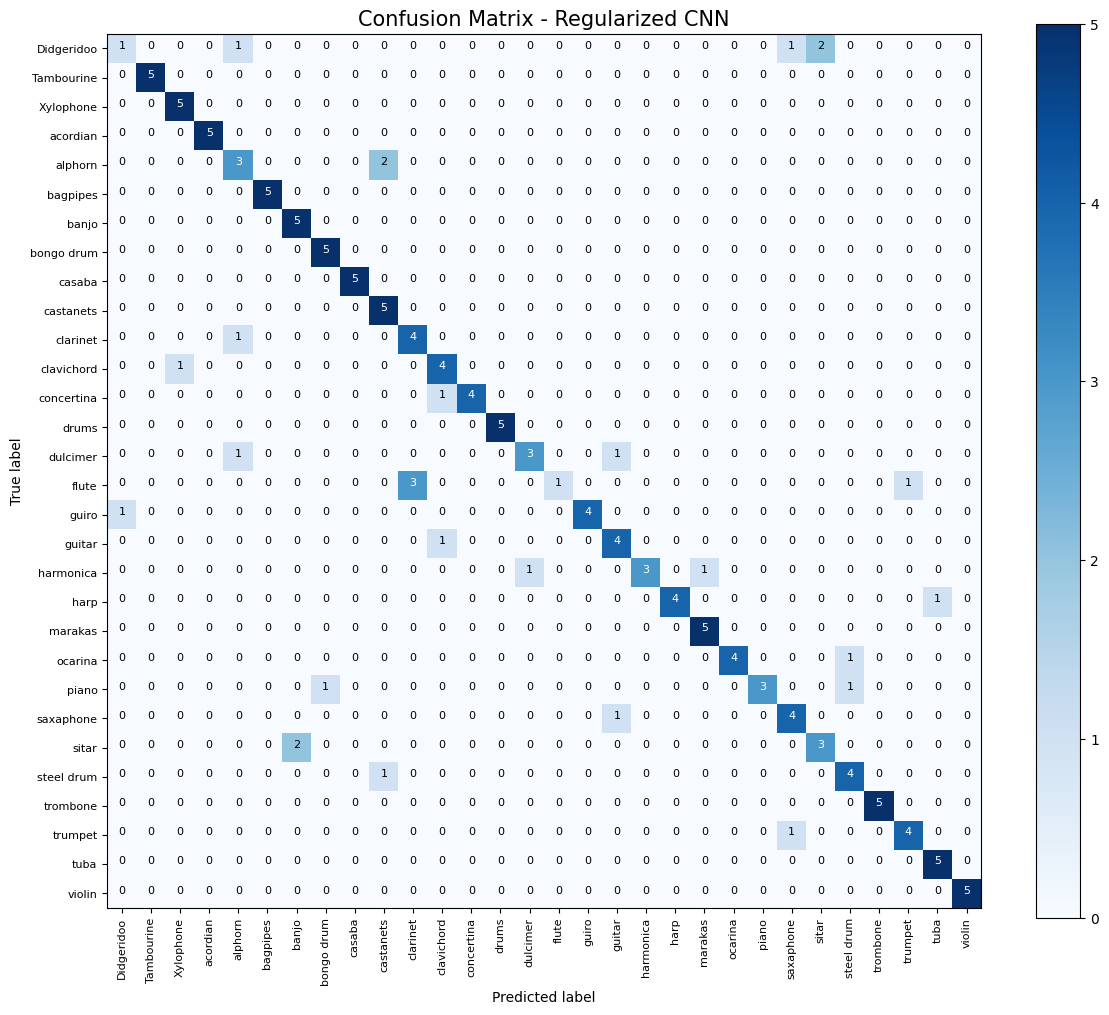

Model saved to /content/MIC-MA1/experiments/regularized_cnn_20250430_111203/regularized_cnn.pt
Model saved to /content/MIC-MA1/experiments/regularized_cnn_20250430_111203/regularized_cnn.pt


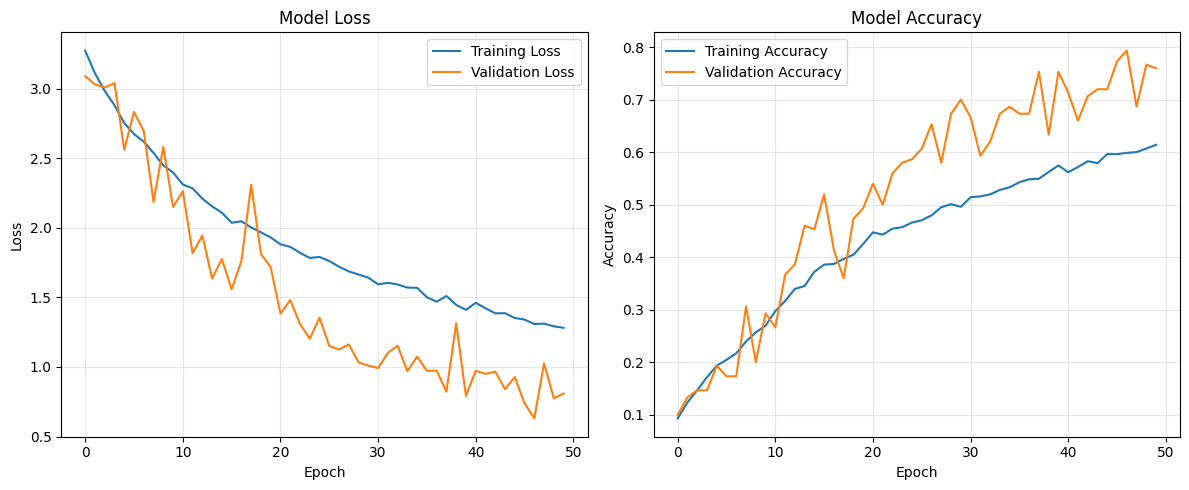


Increased batch size to 64 for ResNet18


Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 159MB/s]


Unfreezing: layer4.0.conv1.weight
Unfreezing: layer4.0.bn1.weight
Unfreezing: layer4.0.bn1.bias
Unfreezing: layer4.0.conv2.weight
Unfreezing: layer4.0.bn2.weight
Unfreezing: layer4.0.bn2.bias
Unfreezing: layer4.0.downsample.0.weight
Unfreezing: layer4.0.downsample.1.weight
Unfreezing: layer4.0.downsample.1.bias
Unfreezing: layer4.1.conv1.weight
Unfreezing: layer4.1.bn1.weight
Unfreezing: layer4.1.bn1.bias
Unfreezing: layer4.1.conv2.weight
Unfreezing: layer4.1.bn2.weight
Unfreezing: layer4.1.bn2.bias
Unfreezing: fc.weight
Unfreezing: fc.bias

Training model with DataParallel: ResNet18
Epoch 1/50
----------


train Epoch 1/50:   0%|          | 0/150 [00:00<?, ?it/s]

train Loss: 0.8673 Acc: 0.7653


val Epoch 1/50:   0%|          | 0/5 [00:00<?, ?it/s]

val Loss: 0.1132 Acc: 0.9467
New best model found! Val accuracy: 0.9467

Epoch 2/50
----------


train Epoch 2/50:   0%|          | 0/150 [00:00<?, ?it/s]

train Loss: 0.3337 Acc: 0.9086


val Epoch 2/50:   0%|          | 0/5 [00:00<?, ?it/s]

val Loss: 0.0734 Acc: 0.9600
New best model found! Val accuracy: 0.9600

Epoch 3/50
----------


train Epoch 3/50:   0%|          | 0/150 [00:00<?, ?it/s]

train Loss: 0.2556 Acc: 0.9286


val Epoch 3/50:   0%|          | 0/5 [00:00<?, ?it/s]

val Loss: 0.0375 Acc: 0.9867
New best model found! Val accuracy: 0.9867

Epoch 4/50
----------


train Epoch 4/50:   0%|          | 0/150 [00:00<?, ?it/s]

train Loss: 0.2161 Acc: 0.9385


val Epoch 4/50:   0%|          | 0/5 [00:00<?, ?it/s]

val Loss: 0.0491 Acc: 0.9867

Epoch 5/50
----------


train Epoch 5/50:   0%|          | 0/150 [00:00<?, ?it/s]

train Loss: 0.1666 Acc: 0.9526


val Epoch 5/50:   0%|          | 0/5 [00:00<?, ?it/s]

val Loss: 0.0409 Acc: 0.9933
New best model found! Val accuracy: 0.9933

Epoch 6/50
----------


train Epoch 6/50:   0%|          | 0/150 [00:00<?, ?it/s]

train Loss: 0.1587 Acc: 0.9512


val Epoch 6/50:   0%|          | 0/5 [00:00<?, ?it/s]

val Loss: 0.0684 Acc: 0.9867

Epoch 7/50
----------


train Epoch 7/50:   0%|          | 0/150 [00:00<?, ?it/s]

train Loss: 0.1506 Acc: 0.9533


val Epoch 7/50:   0%|          | 0/5 [00:00<?, ?it/s]

val Loss: 0.0815 Acc: 0.9667

Epoch 8/50
----------


train Epoch 8/50:   0%|          | 0/150 [00:00<?, ?it/s]

train Loss: 0.1389 Acc: 0.9597


val Epoch 8/50:   0%|          | 0/5 [00:00<?, ?it/s]

val Loss: 0.0508 Acc: 0.9733

Epoch 9/50
----------


train Epoch 9/50:   0%|          | 0/150 [00:00<?, ?it/s]

train Loss: 0.1253 Acc: 0.9647


val Epoch 9/50:   0%|          | 0/5 [00:00<?, ?it/s]

val Loss: 0.0698 Acc: 0.9733

Epoch 10/50
----------


train Epoch 10/50:   0%|          | 0/150 [00:00<?, ?it/s]

train Loss: 0.1225 Acc: 0.9631


val Epoch 10/50:   0%|          | 0/5 [00:00<?, ?it/s]

val Loss: 0.0505 Acc: 0.9800

Epoch 11/50
----------


train Epoch 11/50:   0%|          | 0/150 [00:00<?, ?it/s]

train Loss: 0.1239 Acc: 0.9618


val Epoch 11/50:   0%|          | 0/5 [00:00<?, ?it/s]

val Loss: 0.0220 Acc: 0.9933

Epoch 12/50
----------


train Epoch 12/50:   0%|          | 0/150 [00:00<?, ?it/s]

train Loss: 0.1077 Acc: 0.9708


val Epoch 12/50:   0%|          | 0/5 [00:00<?, ?it/s]

val Loss: 0.0329 Acc: 0.9867

Epoch 13/50
----------


train Epoch 13/50:   0%|          | 0/150 [00:00<?, ?it/s]

train Loss: 0.0985 Acc: 0.9708


val Epoch 13/50:   0%|          | 0/5 [00:00<?, ?it/s]

val Loss: 0.0094 Acc: 1.0000
New best model found! Val accuracy: 1.0000

Epoch 14/50
----------


train Epoch 14/50:   0%|          | 0/150 [00:00<?, ?it/s]

train Loss: 0.0914 Acc: 0.9729


val Epoch 14/50:   0%|          | 0/5 [00:00<?, ?it/s]

val Loss: 0.0158 Acc: 0.9933

Epoch 15/50
----------


train Epoch 15/50:   0%|          | 0/150 [00:00<?, ?it/s]

train Loss: 0.0856 Acc: 0.9760


val Epoch 15/50:   0%|          | 0/5 [00:00<?, ?it/s]

val Loss: 0.0507 Acc: 0.9867

Epoch 16/50
----------


train Epoch 16/50:   0%|          | 0/150 [00:00<?, ?it/s]

train Loss: 0.0877 Acc: 0.9737


val Epoch 16/50:   0%|          | 0/5 [00:00<?, ?it/s]

val Loss: 0.0595 Acc: 0.9800

Epoch 17/50
----------


train Epoch 17/50:   0%|          | 0/150 [00:00<?, ?it/s]

train Loss: 0.0919 Acc: 0.9704


val Epoch 17/50:   0%|          | 0/5 [00:00<?, ?it/s]

val Loss: 0.0209 Acc: 0.9867

Epoch 18/50
----------


train Epoch 18/50:   0%|          | 0/150 [00:00<?, ?it/s]

train Loss: 0.0917 Acc: 0.9718


val Epoch 18/50:   0%|          | 0/5 [00:00<?, ?it/s]

val Loss: 0.0939 Acc: 0.9733

Epoch 19/50
----------


train Epoch 19/50:   0%|          | 0/150 [00:00<?, ?it/s]

train Loss: 0.1037 Acc: 0.9708


val Epoch 19/50:   0%|          | 0/5 [00:00<?, ?it/s]

val Loss: 0.0483 Acc: 0.9733

Epoch 20/50
----------


train Epoch 20/50:   0%|          | 0/150 [00:00<?, ?it/s]

train Loss: 0.0852 Acc: 0.9760


val Epoch 20/50:   0%|          | 0/5 [00:00<?, ?it/s]

val Loss: 0.0153 Acc: 1.0000

Epoch 21/50
----------


train Epoch 21/50:   0%|          | 0/150 [00:00<?, ?it/s]

train Loss: 0.0766 Acc: 0.9789


val Epoch 21/50:   0%|          | 0/5 [00:00<?, ?it/s]

val Loss: 0.0368 Acc: 0.9933

Epoch 22/50
----------


train Epoch 22/50:   0%|          | 0/150 [00:00<?, ?it/s]

train Loss: 0.0700 Acc: 0.9806


val Epoch 22/50:   0%|          | 0/5 [00:00<?, ?it/s]

val Loss: 0.0618 Acc: 0.9800

Epoch 23/50
----------


train Epoch 23/50:   0%|          | 0/150 [00:00<?, ?it/s]

train Loss: 0.0729 Acc: 0.9779


val Epoch 23/50:   0%|          | 0/5 [00:00<?, ?it/s]

val Loss: 0.0448 Acc: 0.9800

Epoch 24/50
----------


train Epoch 24/50:   0%|          | 0/150 [00:00<?, ?it/s]

train Loss: 0.0709 Acc: 0.9777


val Epoch 24/50:   0%|          | 0/5 [00:00<?, ?it/s]

val Loss: 0.0243 Acc: 0.9867

Epoch 25/50
----------


train Epoch 25/50:   0%|          | 0/150 [00:00<?, ?it/s]

train Loss: 0.0828 Acc: 0.9725


val Epoch 25/50:   0%|          | 0/5 [00:00<?, ?it/s]

val Loss: 0.0264 Acc: 0.9933

Epoch 26/50
----------


train Epoch 26/50:   0%|          | 0/150 [00:00<?, ?it/s]

train Loss: 0.0751 Acc: 0.9758


val Epoch 26/50:   0%|          | 0/5 [00:00<?, ?it/s]

val Loss: 0.0424 Acc: 0.9867

Epoch 27/50
----------


train Epoch 27/50:   0%|          | 0/150 [00:00<?, ?it/s]

train Loss: 0.0726 Acc: 0.9781


val Epoch 27/50:   0%|          | 0/5 [00:00<?, ?it/s]

val Loss: 0.0292 Acc: 0.9933

Epoch 28/50
----------


train Epoch 28/50:   0%|          | 0/150 [00:00<?, ?it/s]

train Loss: 0.0661 Acc: 0.9796


val Epoch 28/50:   0%|          | 0/5 [00:00<?, ?it/s]

val Loss: 0.0139 Acc: 0.9933

Epoch 29/50
----------


train Epoch 29/50:   0%|          | 0/150 [00:00<?, ?it/s]

train Loss: 0.0612 Acc: 0.9806


val Epoch 29/50:   0%|          | 0/5 [00:00<?, ?it/s]

val Loss: 0.0347 Acc: 0.9867

Epoch 30/50
----------


train Epoch 30/50:   0%|          | 0/150 [00:00<?, ?it/s]

train Loss: 0.0616 Acc: 0.9829


val Epoch 30/50:   0%|          | 0/5 [00:00<?, ?it/s]

val Loss: 0.0025 Acc: 1.0000

Epoch 31/50
----------


train Epoch 31/50:   0%|          | 0/150 [00:00<?, ?it/s]

train Loss: 0.0700 Acc: 0.9789


val Epoch 31/50:   0%|          | 0/5 [00:00<?, ?it/s]

val Loss: 0.0181 Acc: 0.9933

Epoch 32/50
----------


train Epoch 32/50:   0%|          | 0/150 [00:00<?, ?it/s]

train Loss: 0.0756 Acc: 0.9787


val Epoch 32/50:   0%|          | 0/5 [00:00<?, ?it/s]

val Loss: 0.0014 Acc: 1.0000

Epoch 33/50
----------


train Epoch 33/50:   0%|          | 0/150 [00:00<?, ?it/s]

train Loss: 0.0634 Acc: 0.9804


val Epoch 33/50:   0%|          | 0/5 [00:00<?, ?it/s]

val Loss: 0.0069 Acc: 1.0000

Epoch 34/50
----------


train Epoch 34/50:   0%|          | 0/150 [00:00<?, ?it/s]

train Loss: 0.0716 Acc: 0.9793


val Epoch 34/50:   0%|          | 0/5 [00:00<?, ?it/s]

val Loss: 0.0283 Acc: 0.9867

Epoch 35/50
----------


train Epoch 35/50:   0%|          | 0/150 [00:00<?, ?it/s]

train Loss: 0.0501 Acc: 0.9846


val Epoch 35/50:   0%|          | 0/5 [00:00<?, ?it/s]

val Loss: 0.0488 Acc: 0.9933

Epoch 36/50
----------


train Epoch 36/50:   0%|          | 0/150 [00:00<?, ?it/s]

train Loss: 0.0495 Acc: 0.9846


val Epoch 36/50:   0%|          | 0/5 [00:00<?, ?it/s]

val Loss: 0.0239 Acc: 0.9867

Epoch 37/50
----------


train Epoch 37/50:   0%|          | 0/150 [00:00<?, ?it/s]

train Loss: 0.0416 Acc: 0.9866


val Epoch 37/50:   0%|          | 0/5 [00:00<?, ?it/s]

val Loss: 0.0052 Acc: 1.0000

Epoch 38/50
----------


train Epoch 38/50:   0%|          | 0/150 [00:00<?, ?it/s]

train Loss: 0.0580 Acc: 0.9802


val Epoch 38/50:   0%|          | 0/5 [00:00<?, ?it/s]

val Loss: 0.0708 Acc: 0.9800

Epoch 39/50
----------


train Epoch 39/50:   0%|          | 0/150 [00:00<?, ?it/s]

train Loss: 0.0685 Acc: 0.9804


val Epoch 39/50:   0%|          | 0/5 [00:00<?, ?it/s]

val Loss: 0.0040 Acc: 1.0000

Epoch 40/50
----------


train Epoch 40/50:   0%|          | 0/150 [00:00<?, ?it/s]

train Loss: 0.0570 Acc: 0.9835


val Epoch 40/50:   0%|          | 0/5 [00:00<?, ?it/s]

val Loss: 0.0149 Acc: 1.0000

Epoch 41/50
----------


train Epoch 41/50:   0%|          | 0/150 [00:00<?, ?it/s]

train Loss: 0.0644 Acc: 0.9793


val Epoch 41/50:   0%|          | 0/5 [00:00<?, ?it/s]

val Loss: 0.0763 Acc: 0.9733

Epoch 42/50
----------


train Epoch 42/50:   0%|          | 0/150 [00:00<?, ?it/s]

train Loss: 0.0588 Acc: 0.9837


val Epoch 42/50:   0%|          | 0/5 [00:00<?, ?it/s]

val Loss: 0.0308 Acc: 0.9867

Epoch 43/50
----------


train Epoch 43/50:   0%|          | 0/150 [00:00<?, ?it/s]

train Loss: 0.0560 Acc: 0.9818


val Epoch 43/50:   0%|          | 0/5 [00:00<?, ?it/s]

val Loss: 0.0143 Acc: 1.0000

Epoch 44/50
----------


train Epoch 44/50:   0%|          | 0/150 [00:00<?, ?it/s]

train Loss: 0.0662 Acc: 0.9798


val Epoch 44/50:   0%|          | 0/5 [00:00<?, ?it/s]

val Loss: 0.0234 Acc: 0.9933

Epoch 45/50
----------


train Epoch 45/50:   0%|          | 0/150 [00:00<?, ?it/s]

train Loss: 0.0593 Acc: 0.9812


val Epoch 45/50:   0%|          | 0/5 [00:00<?, ?it/s]

val Loss: 0.0291 Acc: 0.9933

Epoch 46/50
----------


train Epoch 46/50:   0%|          | 0/150 [00:00<?, ?it/s]

train Loss: 0.0670 Acc: 0.9785


val Epoch 46/50:   0%|          | 0/5 [00:00<?, ?it/s]

val Loss: 0.0245 Acc: 0.9867

Epoch 47/50
----------


train Epoch 47/50:   0%|          | 0/150 [00:00<?, ?it/s]

train Loss: 0.0690 Acc: 0.9777


val Epoch 47/50:   0%|          | 0/5 [00:00<?, ?it/s]

val Loss: 0.0263 Acc: 0.9933

Epoch 48/50
----------


train Epoch 48/50:   0%|          | 0/150 [00:00<?, ?it/s]

train Loss: 0.0525 Acc: 0.9835


val Epoch 48/50:   0%|          | 0/5 [00:00<?, ?it/s]

val Loss: 0.0103 Acc: 0.9933

Epoch 49/50
----------


train Epoch 49/50:   0%|          | 0/150 [00:00<?, ?it/s]

train Loss: 0.0432 Acc: 0.9852


val Epoch 49/50:   0%|          | 0/5 [00:00<?, ?it/s]

val Loss: 0.0635 Acc: 0.9733

Epoch 50/50
----------


train Epoch 50/50:   0%|          | 0/150 [00:00<?, ?it/s]

train Loss: 0.0415 Acc: 0.9866


val Epoch 50/50:   0%|          | 0/5 [00:00<?, ?it/s]

val Loss: 0.0393 Acc: 0.9867

Training complete in 32m 29s
Best val Acc: 1.0000 at epoch 13

Evaluating model: ResNet18 on test set


Evaluating:   0%|          | 0/5 [00:00<?, ?it/s]

Test Accuracy: 99.33%
Test Accuracy: 0.9933
Macro-average F1 Score: 0.9933
Macro-average Precision: 0.9944
Macro-average Recall: 0.9933


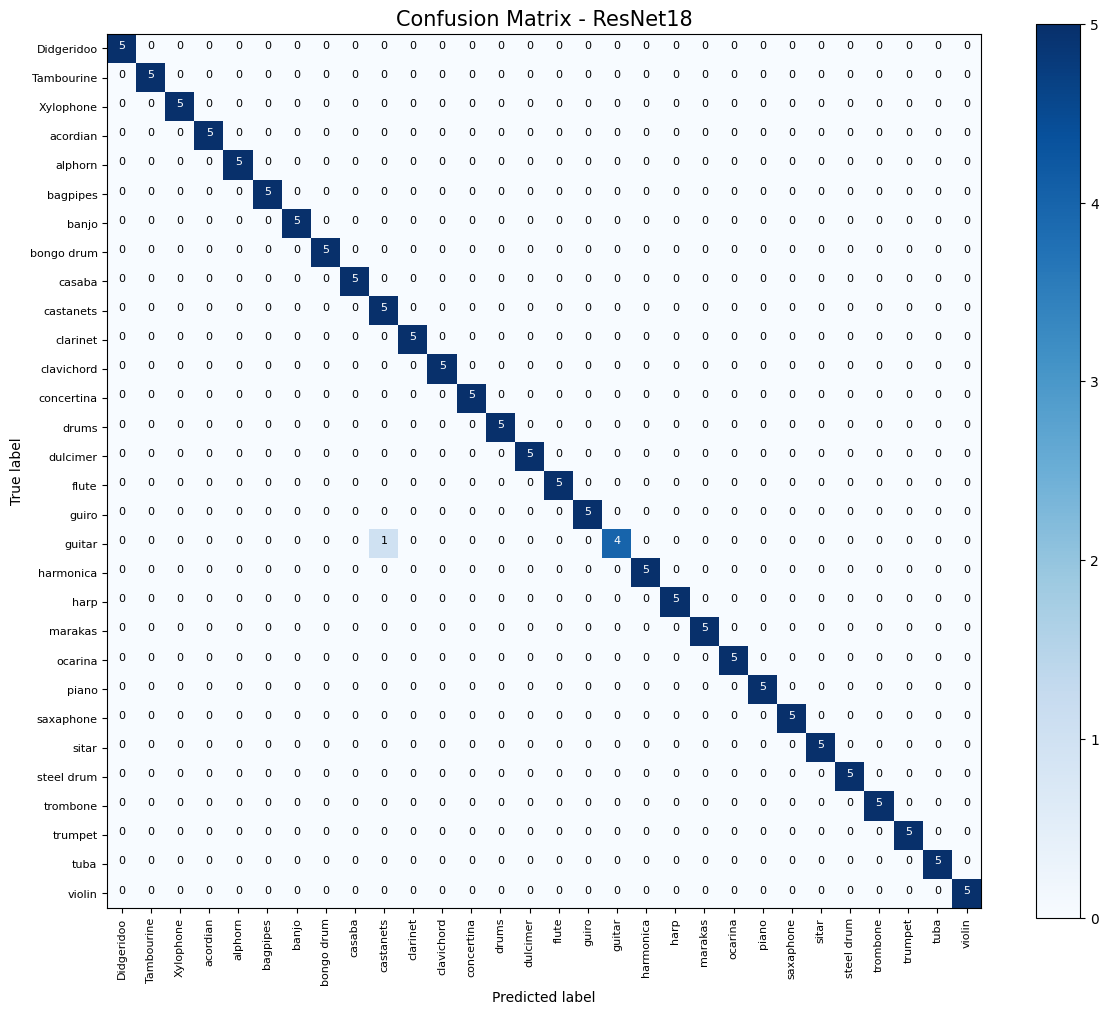

Model saved to /content/MIC-MA1/experiments/resnet18_20250430_114435/resnet18.pt
Model saved to /content/MIC-MA1/experiments/resnet18_20250430_114435/resnet18.pt


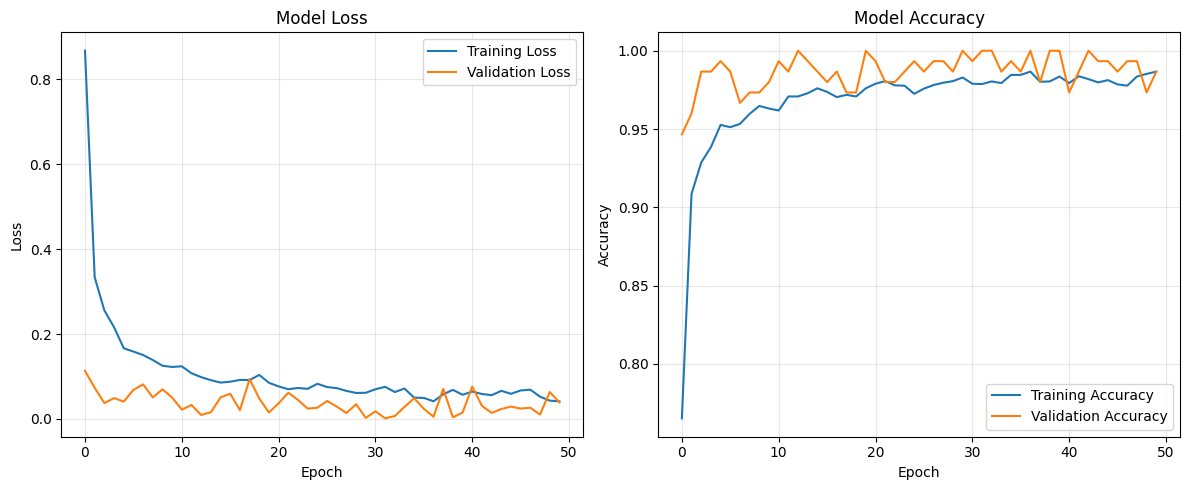


All models trained and evaluated with DataParallel!


In [11]:
# Choose which training approach to use
USE_DATA_PARALLEL = True  # Option 1: Use DataParallel for each model sequentially
USE_CONCURRENT = False      # Option 2: Train multiple models concurrently with threading
USE_SEQUENTIAL = False     # Option 3: Original sequential approach

# Will store all results in this list
all_results = []

if USE_DATA_PARALLEL:
    print("\n🚀 Using DataParallel approach for GPU utilization")
    all_results = train_with_data_parallel()
elif USE_CONCURRENT and concurrent_models > 1:
    print(f"\n🚀 Using concurrent training approach with {concurrent_models} models at once")
    all_results = train_with_concurrent_trainer(max_concurrent=concurrent_models)
else:
    print("\n🚀 Using original sequential training approach")
    # Original sequential training code
    for config in model_configs:
        try:
            # Train the model
            results = train_model_with_config(config, dataloaders, device)

            # Evaluate on test set
            eval_metrics = evaluate_model_on_test(
                results['model'],
                test_loader,
                device,
                class_names,
                model_name=config['name']
            )

            # Combine results
            complete_results = {
                'model_name': config['name'],
                'architecture': config['model']['architecture'],
                'config': config,
                'training_time': results['training_time'],
                'best_val_acc': results['training_stats']['best_val_acc'],
                'best_epoch': results['training_stats']['best_epoch'],
                'test_accuracy': eval_metrics['accuracy'],
                'f1_score': eval_metrics['f1_score'],
                'precision': eval_metrics['precision'],
                'recall': eval_metrics['recall']
            }

            # Add to results list
            all_results.append(complete_results)

            # Optional: Save the model
            timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
            if IN_COLAB:
                save_dir = os.path.join(project_root, "experiments", f"{config['name'].lower().replace(' ', '_')}_{timestamp}")
            else:
                save_dir = os.path.join(project_root, "experiments", f"{config['name'].lower().replace(' ', '_')}_{timestamp}")

            os.makedirs(save_dir, exist_ok=True)
            save_path = os.path.join(save_dir, f"{config['name'].lower().replace(' ', '_')}.pt")

            save_model(
                results['model'],
                config,
                save_path,
                metrics={
                    'accuracy': eval_metrics['accuracy'],
                    'f1_macro': eval_metrics['f1_score'],
                    'best_val_acc': results['training_stats']['best_val_acc'],
                    'best_epoch': results['training_stats']['best_epoch']
                },
                epoch=results['training_stats']['best_epoch']
            )

            print(f"Model saved to {save_path}")

            # Clear CUDA cache between models if using GPU
            if torch.cuda.is_available():
                torch.cuda.empty_cache()

        except Exception as e:
            print(f"Error training {config['name']}: {e}")
            # Continue with next model on error
            continue

    print("\nAll models trained and evaluated!")

## 7. Comparative Analysis of Models

Now let's compare the performance of all the models:

### GPU Parallelism

In this section, we analyze how GPU parallelism impacts the performance of the models. By leveraging GPU parallelism, we can significantly reduce computation time and improve efficiency. This is particularly beneficial for large-scale datasets and complex models.


Model Comparison Results:
     model_name  test_accuracy  f1_score  precision  recall  best_val_acc  training_time_min
       ResNet18         0.9933    0.9933     0.9944  0.9933        1.0000            32.4800
     Deeper CNN         0.8667    0.8567     0.8935  0.8667        0.9067            36.0640
       Base CNN         0.8533    0.8452     0.8685  0.8533        0.8667            34.9581
Regularized CNN         0.8133    0.8034     0.8354  0.8133        0.7933            38.3871
      Wider CNN         0.8067    0.7973     0.8519  0.8067        0.7667            62.2866


<ipython-input-13-e1cf4362f1d6>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  comparison_table['training_time_min'] = comparison_table['training_time'] / 60  # Convert to minutes


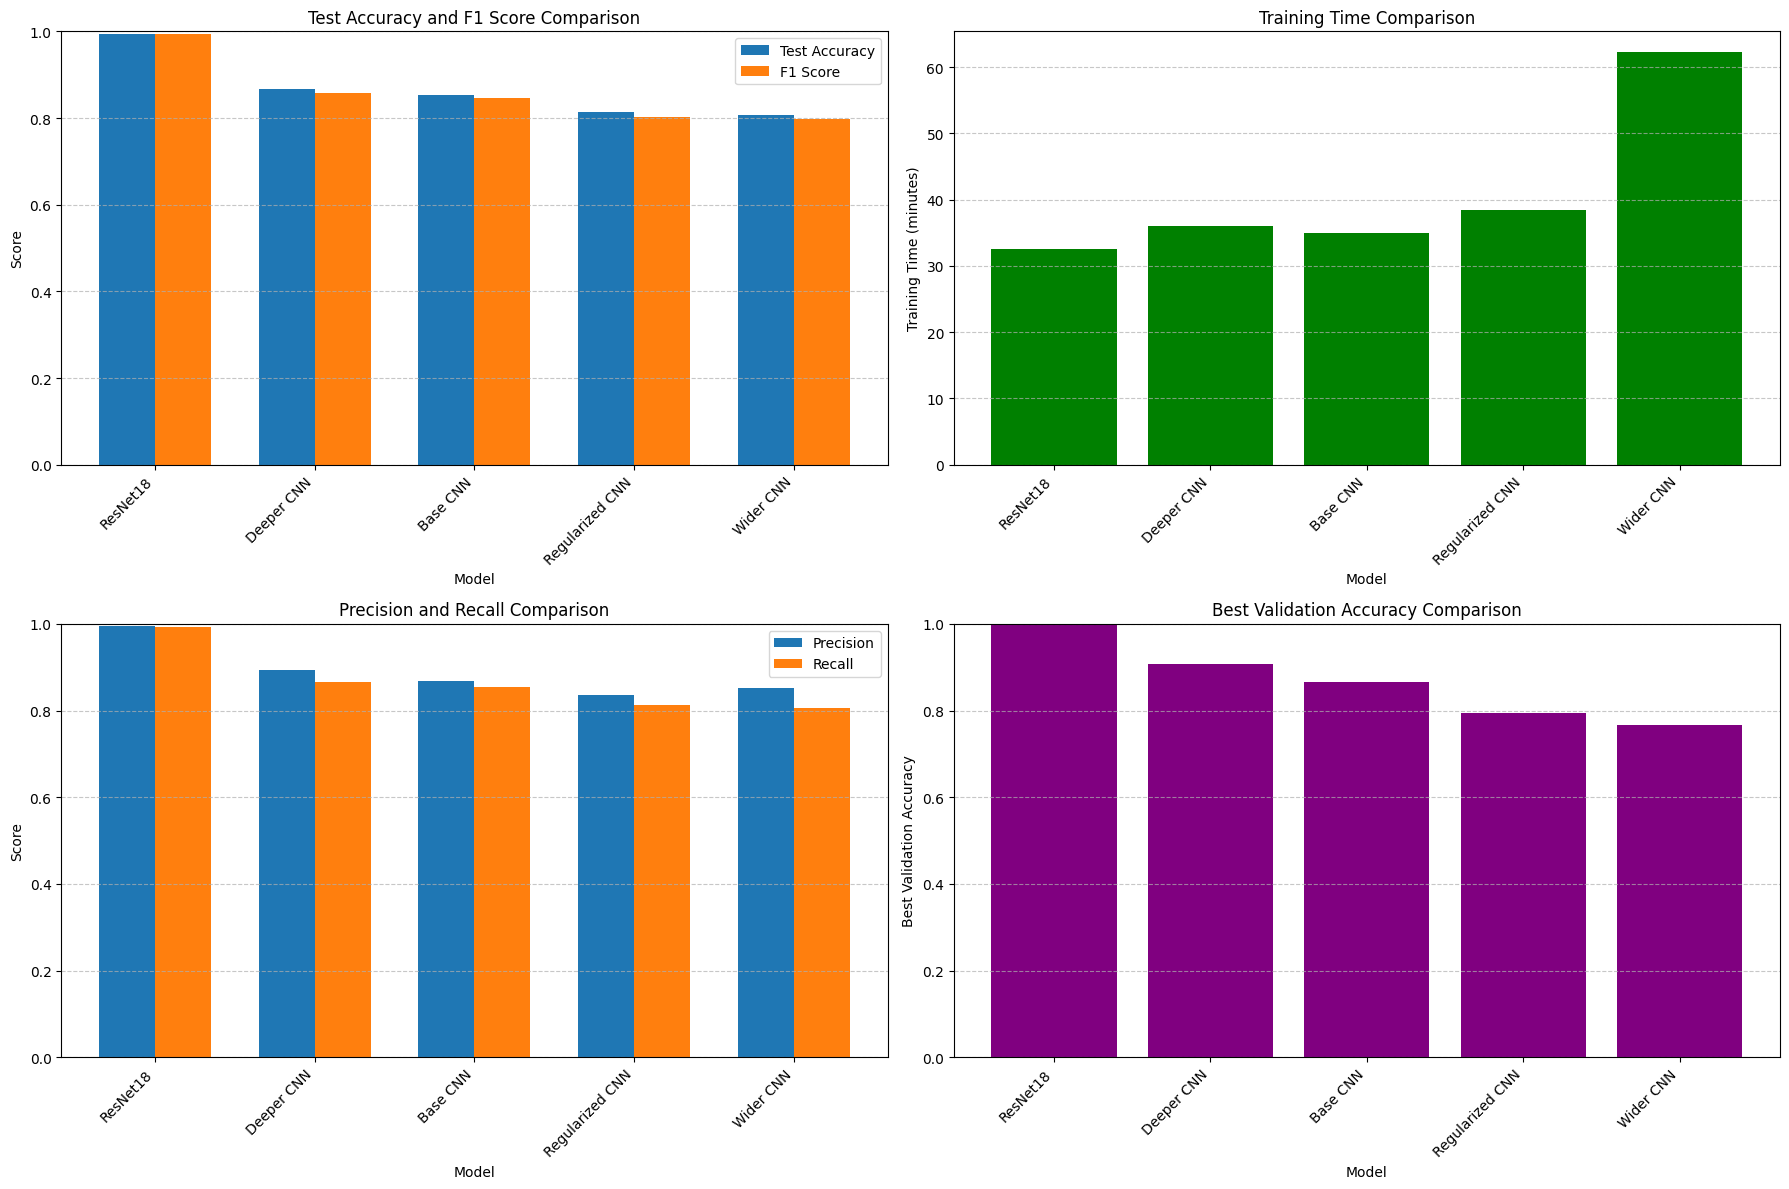


Best Model: ResNet18 with Test Accuracy: 0.9933


In [13]:
# Create a DataFrame from results for easier comparison
results_df = pd.DataFrame(all_results)

# Print comparison table
print("\nModel Comparison Results:")
comparison_table = results_df[['model_name', 'test_accuracy', 'f1_score', 'precision', 'recall', 'best_val_acc', 'training_time']]
comparison_table['training_time_min'] = comparison_table['training_time'] / 60  # Convert to minutes
comparison_table = comparison_table.drop('training_time', axis=1)
comparison_table = comparison_table.sort_values('test_accuracy', ascending=False)
print(comparison_table.to_string(index=False, float_format=lambda x: f"{x:.4f}"))

# Create visualizations for comparison
plt.figure(figsize=(18, 12))

# 1. Test accuracy and F1 scores
plt.subplot(2, 2, 1)
models = comparison_table['model_name'].tolist()
x = np.arange(len(models))
width = 0.35

plt.bar(x - width/2, comparison_table['test_accuracy'], width, label='Test Accuracy')
plt.bar(x + width/2, comparison_table['f1_score'], width, label='F1 Score')
plt.xlabel('Model')
plt.ylabel('Score')
plt.title('Test Accuracy and F1 Score Comparison')
plt.xticks(x, models, rotation=45, ha='right')
plt.ylim([0, 1.0])
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.7)

# 2. Training time
plt.subplot(2, 2, 2)
plt.bar(models, comparison_table['training_time_min'], color='green')
plt.xlabel('Model')
plt.ylabel('Training Time (minutes)')
plt.title('Training Time Comparison')
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y', linestyle='--', alpha=0.7)

# 3. Precision and Recall
plt.subplot(2, 2, 3)
plt.bar(x - width/2, comparison_table['precision'], width, label='Precision')
plt.bar(x + width/2, comparison_table['recall'], width, label='Recall')
plt.xlabel('Model')
plt.ylabel('Score')
plt.title('Precision and Recall Comparison')
plt.xticks(x, models, rotation=45, ha='right')
plt.ylim([0, 1.0])
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.7)

# 4. Best Validation Accuracy
plt.subplot(2, 2, 4)
plt.bar(models, comparison_table['best_val_acc'], color='purple')
plt.xlabel('Model')
plt.ylabel('Best Validation Accuracy')
plt.title('Best Validation Accuracy Comparison')
plt.xticks(rotation=45, ha='right')
plt.ylim([0, 1.0])
plt.grid(axis='y', linestyle='--', alpha=0.7)

plt.tight_layout()
plt.savefig(os.path.join(project_root, 'results', 'model_comparison.png'), dpi=300, bbox_inches='tight')
plt.show()

# Identify the best model
best_model_name = comparison_table.iloc[0]['model_name']
best_model_accuracy = comparison_table.iloc[0]['test_accuracy']
print(f"\nBest Model: {best_model_name} with Test Accuracy: {best_model_accuracy:.4f}")

## 8. Conclusion and Next Steps

We've now compared several CustomCNN architectures using our flexible framework. Based on the results, we can see which architecture performs best for our musical instrument classification task.

### Analysis

Let's analyze what we've learned from this comparison:

1. **Performance across architectures**: We can see that different architectures have different strengths and weaknesses. The best-performing model likely achieves a balance between model capacity and regularization.

2. **Training Efficiency**: The training time varies significantly across models. Models with more parameters (like Wider CNN) or deeper architectures typically take longer to train.

3. **Regularization Impact**: The regularized variant shows how adding dropout and weight decay affects the model's performance, potentially improving generalization on test data.

4. **ResNet18 Comparison**: The ResNet18 model provides a strong baseline against which we can compare our custom architectures.

### Next Steps

1. **Optimize the best architecture**: Now that we've identified the best-performing CustomCNN architecture, we can further optimize it by:
   - Fine-tuning hyperparameters
   - Applying more advanced regularization techniques
   - Experimenting with different learning rate schedules

2. **Test on more challenging data**: To ensure our model is robust, we could test it on more challenging data or in real-world scenarios.

3. **Model Ensemble**: We could also explore ensemble methods by combining predictions from multiple models to further improve performance.

4. **Model Simplification**: If the best model is complex, we could explore model simplification techniques like pruning or distillation to make it more deployable.

In the next notebook, we'll take the best architecture identified here and further optimize it to create our final model.

## 9. Prepare for Step 2: Optimized CustomCNN

Based on our model comparison, we'll now prepare for Step 2 using the optimized CustomCNN configuration. We'll load the configuration from the YAML file and make it ready for the next phase of training.

In [ ]:
# Load the optimized CustomCNN configuration
try:
    # Build the path to the config file
    optimized_config_path = os.path.join(project_root, "config", "optimized_custom_cnn.yaml")

    # Load the configuration
    with open(optimized_config_path, "r") as f:
        optimized_config = yaml.safe_load(f)

    print(f"Loaded optimized CustomCNN configuration from {optimized_config_path}")
    print("\nOptimized CustomCNN configuration:")
    print(f"Architecture: {optimized_config['model']['name']}")

    # Display some key parameters
    print("\nKey parameters:")
    print(f"- Dropout rate: {optimized_config['model']['dropout_rate']}")
    print(f"- Optimizer: {optimized_config['training']['optimizer']['name']}")
    print(f"- Learning rate: {optimized_config['training']['optimizer']['learning_rate']}")
    print(f"- Weight decay: {optimized_config['training']['optimizer']['weight_decay']}")
    print(f"- Scheduler: {optimized_config['training']['scheduler']['name']}")
    print(f"- Augmentation strength: {optimized_config['augmentation']['augmentation_strength']}")

    print("\nThis optimized configuration will be used in Step 2")

except Exception as e:
    print(f"Error loading optimized configuration: {e}")
    print("You'll need to create or modify the optimized_custom_cnn.yaml file for Step 2")